In [6]:
import warnings;
warnings.simplefilter('ignore')

In [9]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('../')

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt

from scripts import datasources
from scripts import models
from scripts import variables

ModuleNotFoundError: No module named 'scripts'

In [8]:
# from scripts import datasources, models, variables, utils

ModuleNotFoundError: No module named 'scripts'

In [6]:
# mm.initialize()

## Generating accesibility variables

In [7]:
orca.run(['initialize_network_small', 'network_aggregations_small'])

orca.run(['initialize_network_walk', 'network_aggregations_walk'])

print()

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Removed 189769 rows because they contain missing values
Computing hh_10000
Removed 189769 rows because they contain missing values
Computing poor_10000
Removed 53114 rows because they contain missing values
Computing renters_10000
Removed 102597 rows because they contain missing values
Computing avg_income_10000
Removed 189769 rows because they contain missing values
Computing jobs_10000
Computing avg_rent_10000
Computing med_rent_10000
Computing pop_white_10000
Removed 107372 rows because they contain missing values
Computing pop_black_10000
Removed 10541 rows because they contain missing values
Computing pop_asian_10000
Removed 51048 rows because they contain missing values
Computing pop_hisp_10000
Removed 31685 rows because

Removed 107372 rows because they contain missing values
Computing pop_black_1500_walk
Removed 10541 rows because they contain missing values
Computing pop_asian_1500_walk
Removed 51048 rows because they contain missing values
Computing pop_hisp_1500_walk
Removed 31685 rows because they contain missing values
Computing pop_2500_walk
Removed 189769 rows because they contain missing values
Computing pop_white_2500_walk
Removed 107372 rows because they contain missing values
Computing pop_black_2500_walk
Removed 10541 rows because they contain missing values
Computing pop_asian_2500_walk
Removed 51048 rows because they contain missing values
Computing pop_hisp_2500_walk
Removed 31685 rows because they contain missing values
Computing jobs_500_walk_retail
Computing jobs_1500_walk_retail
Computing jobs_2500_walk_retail
Computing jobs_500_walk_fire
Computing jobs_1500_walk_fire
Computing jobs_2500_walk_fire
Computing jobs_500_walk_tech
Computing jobs_1500_walk_tech
Computing jobs_2500_walk_te

## Loading data

In [8]:
#Loading am peak transit accessibility varaibles
@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
persons = orca.get_table('persons').to_frame()
parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
# nodessmall = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
nodessmall.index.name = 'node_id_small'
nodeswalk = orca.get_table('nodeswalk').to_frame()
# nodeswalk = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
nodeswalk.index.name = 'node_id_walk'
am_acc = orca.get_table('am_acc').to_frame()

In [57]:
#Creating a Parcel Table with accessibility variables 

# Merging transit accessibility to parcels (Have to do this manually because orca.merge_tables performs inner merge only)
parcels_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('primary_id')

#Filling transit accessibility NA with median value and adding columns to the parcelDataFrame in orca
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('primary_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('primary_id')



## Merging process

### Synthetic population

In [10]:
# Merging transit accessibility to parcels (Have to do this manually because orca.merge_tables performs inner merge only)
parcels_with_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('primary_id')

#Filling transit accessibility NA with median value and adding columns to the parcelDataFrame in orca
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

#Merging parcel to househols
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'])
    return df

#Uploading merge df
hh_merged = orca.get_table('hh_merged').to_frame()

#Merging nodessmall and nodeswalk to household
hh_merged = hh_merged.merge(nodessmall, how = 'left', left_on = 'node_id_small', right_index= True
                           ).merge(nodeswalk, how = 'left', left_on = 'node_id_walk', right_index= True )

#Generating household variables from the persons table 
hh_16_younger = persons[persons['age'] < 16].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_16_younger'})
hh_70_older = persons[persons['age'] > 70].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_70_older'})
hh_students = persons[persons['student'] == 1].groupby(by='household_id').agg({'student':'count'}).rename(columns={'student': 'hh_student'})
hh_work_home = persons[persons['work_at_home'] == 1].groupby(by='household_id').agg({'work_at_home':'count'}).rename(columns={'work_at_home': 'hh_work_home'})

# Merging variables to hh_merged
hh_merged = hh_merged .merge(hh_16_younger, on = 'household_id', how = 'left'
                           ).merge(hh_70_older, on ='household_id', how = 'left'
                                  ).merge(hh_students, on= 'household_id',how = 'left'
                                         ).merge(hh_work_home, on= 'household_id', how = 'left')

# Filling NA with zeros 
values = {'hh_16_younger': 0, 'hh_70_older': 0, 'hh_student': 0, 'hh_work_home': 0}
hh_merged = hh_merged.fillna(value=values)


#Filter repited values is any
filter_col = [col for col in hh_merged if (col.endswith('_y')) | (col.endswith('_x'))]

if len(filter_col) != 0:
    hh_merged = hh_merged.drop(columns=filter_col)

In [59]:
# Additional Jayne's code for MNL 
# # income bins
# income_bins = pd.cut(orca.get_table('households').to_frame().income,
#       bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
#       labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
# income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
# for i in income_bin_dummies.columns:
#     orca.add_column('households',i,income_bin_dummies[i])

# # tenure type dummy
# orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
# orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
# orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
# orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# # single family as integer
# orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# # building type dummy
# orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))

# county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
# for i in county_dummies.columns:
#     orca.add_column('parcels',i,county_dummies[i])

# acc_cols = list(orca.get_table('nodessmall').to_frame().columns) + list(orca.get_table('nodeswalk').to_frame().columns) + list(set(parcels_with_acc.columns) - set(parcels))

### CHTS data

In [493]:
persons_chts = pd.read_csv('/home/data/fall_2018/chts_persons_w_zone_ids.csv')
household_chts = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_HH.csv")

In [494]:
# Variables in the persons table
persons_chts['worker'] = [1 if x == 1 else 0 for x in persons_chts['EMPLY']]
persons_chts['children'] = [1 if x < 18 else 0 for x in persons_chts.AGE]
persons_chts['TransitPass'] = persons_chts.TRANS.apply(lambda x: 1 if x == 1 else 0)

# #Creating person-based variables to merge onto Household table
person_var = persons_chts.groupby(by ='SAMPN').agg({'PERNO': 'count',
                                                    'AGE': 'first',
                                                    'zone_id_home': 'first',
                                                    'EMPLY':'sum', 
                                                    'children':'sum',
                                                    'TransitPass':'sum',
                                                    'parcel_id_home': 'first'})

household_chts = household_chts.merge(person_var, how = 'left', left_on = 'SAMPN', right_index=True )
household_chts = household_chts.dropna(subset=['PERNO', 'AGE', 'zone_id_home', 'children'])


for i in to_normalize:
    df[i] = normalize(df[i])

In [229]:
parcels_with_acc.head()

,serialno,persons,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,state,...,tenure_3,tenure_4,single_family_int,building_type_2,hh_inc_150kplus,hh_size_1per,hh_16_younger,hh_70_older,hh_student,hh_work_home
household_id,,,,,,,,,,,,,,,,,,,,,
14127,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
17257,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
24020,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
28196,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
33517,2013000084437,5.0,8.0,3.0,75700.0,1,no,71,4.0,6,...,0,0,0,0,0,0,1,1,3,2


In [30]:
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [31]:
# Variables in the persons table
persons_chts['worker'] = [1 if x == 1 else 0 for x in persons_chts['EMPLY']]
persons_chts['children'] = [1 if x < 18 else 0 for x in persons_chts.AGE]
persons_chts['TransitPass'] = persons_chts.TRANS.apply(lambda x: 1 if x == 1 else 0)

# #Creating person-based variables to merge onto Household table
person_var = persons_chts.groupby(by ='SAMPN').agg({'PERNO': 'count',
                                                    'AGE': 'first',
                                                    'zone_id_home': 'first',
                                                    'EMPLY':'sum', 
                                                    'children':'sum',
                                                    'TransitPass':'sum',
                                                    'parcel_id_home': 'first'})

household_chts = household_chts.merge(person_var, how = 'left', left_on = 'SAMPN', right_index=True )
household_chts = household_chts.dropna(subset=['PERNO', 'AGE', 'zone_id_home', 'children'])


for i in to_normalize:
    df[i] = normalize(df[i])

In [229]:
parcels_with_acc.head()

,serialno,persons,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,state,...,tenure_3,tenure_4,single_family_int,building_type_2,hh_inc_150kplus,hh_size_1per,hh_16_younger,hh_70_older,hh_student,hh_work_home
household_id,,,,,,,,,,,,,,,,,,,,,
14127,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
17257,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
24020,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
28196,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
33517,2013000084437,5.0,8.0,3.0,75700.0,1,no,71,4.0,6,...,0,0,0,0,0,0,1,1,3,2


In [30]:
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [31]:
# Variables in the persons table
persons_chts['worker'] = [1 if x == 1 else 0 for x in persons_chts['EMPLY']]
persons_chts['children'] = [1 if x < 18 else 0 for x in persons_chts.AGE]
persons_chts['TransitPass'] = persons_chts.TRANS.apply(lambda x: 1 if x == 1 else 0)

# #Creating person-based variables to merge onto Household table
person_var = persons_chts.groupby(by ='SAMPN').agg({'PERNO': 'count',
                                                    'AGE': 'first',
                                                    'zone_id_home': 'first',
                                                    'EMPLY':'sum', 
                                                    'children':'sum',
                                                    'TransitPass':'sum',
                                                    'parcel_id_home': 'first'})

household_chts = household_chts.merge(person_var, how = 'left', left_on = 'SAMPN', right_index=True )
household_chts = household_chts.dropna(subset=['PERNO', 'AGE', 'zone_id_home', 'children'])


for i in to_normalize:
    df[i] = normalize(df[i])

In [229]:
parcels_with_acc.head()

,serialno,persons,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,state,...,tenure_3,tenure_4,single_family_int,building_type_2,hh_inc_150kplus,hh_size_1per,hh_16_younger,hh_70_older,hh_student,hh_work_home
household_id,,,,,,,,,,,,,,,,,,,,,
14127,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
17257,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
24020,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
28196,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
33517,2013000084437,5.0,8.0,3.0,75700.0,1,no,71,4.0,6,...,0,0,0,0,0,0,1,1,3,2


In [30]:
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [31]:
# Variables in the persons table
persons_chts['worker'] = [1 if x == 1 else 0 for x in persons_chts['EMPLY']]
persons_chts['children'] = [1 if x < 18 else 0 for x in persons_chts.AGE]
persons_chts['TransitPass'] = persons_chts.TRANS.apply(lambda x: 1 if x == 1 else 0)

# #Creating person-based variables to merge onto Household table
person_var = persons_chts.groupby(by ='SAMPN').agg({'PERNO': 'count',
                                                    'AGE': 'first',
                                                    'zone_id_home': 'first',
                                                    'EMPLY':'sum', 
                                                    'children':'sum',
                                                    'TransitPass':'sum',
                                                    'parcel_id_home': 'first'})

household_chts = household_chts.merge(person_var, how = 'left', left_on = 'SAMPN', right_index=True )
household_chts = household_chts.dropna(subset=['PERNO', 'AGE', 'zone_id_home', 'children'])


for i in to_normalize:
    df[i] = normalize(df[i])

In [229]:
hh_merge = households.merge(hh_16_younger, on = 'household_id',
                           ).merge(hh_70_older, on ='household_id',
                                  ).merge(hh_students, on= 'household_id',
                                         ).merge(hh_work_home, on= 'household_id' )

hh_merge.head(5)

,serialno,persons,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,state,...,tenure_3,tenure_4,single_family_int,building_type_2,hh_inc_150kplus,hh_size_1per,hh_16_younger,hh_70_older,hh_student,hh_work_home
household_id,,,,,,,,,,,,,,,,,,,,,
14127,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
17257,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
24020,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
28196,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
33517,2013000084437,5.0,8.0,3.0,75700.0,1,no,71,4.0,6,...,0,0,0,0,0,0,1,1,3,2


In [47]:
hh_merge['cars_alt'] = hh_merge['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))


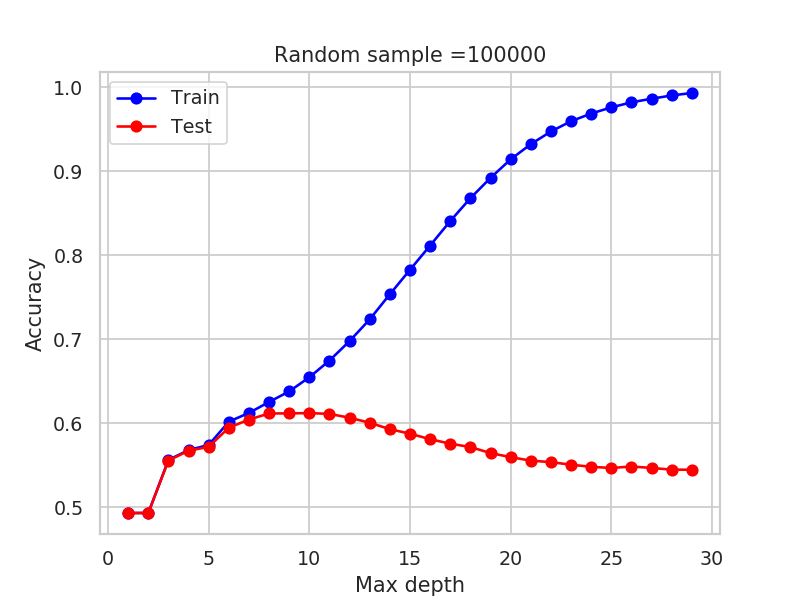

In [48]:
sample_size = 100000
df_data_jayne = df.sample(n= sample_size, random_state= 234)
x = df_data_jayne.drop(labels = 'cars_alt', axis =1)
y = df_data_jayne['cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)
    
result_train = []
result_test = []
max_depth = range(1,30)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
     
plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Random sample =' + str(sample_size))
plt.legend()

<IPython.core.display.Javascript object>

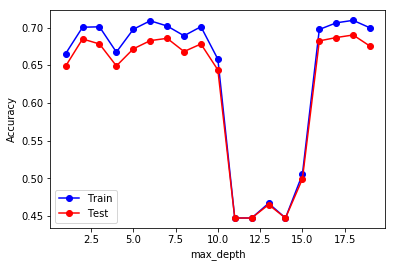

In [241]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=7)
scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
scores

In [43]:
result_train = []
result_test = []
max_depth = range(1,10)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 


0.6116060606060606


col_0            0         1         2         3
cars_alt                                        
0         0.386697  0.500188  0.090943  0.022172
1         0.053884  0.683865  0.224602  0.037649
2         0.009274  0.196963  0.666968  0.126795
3         0.004067  0.068893  0.414222  0.512817
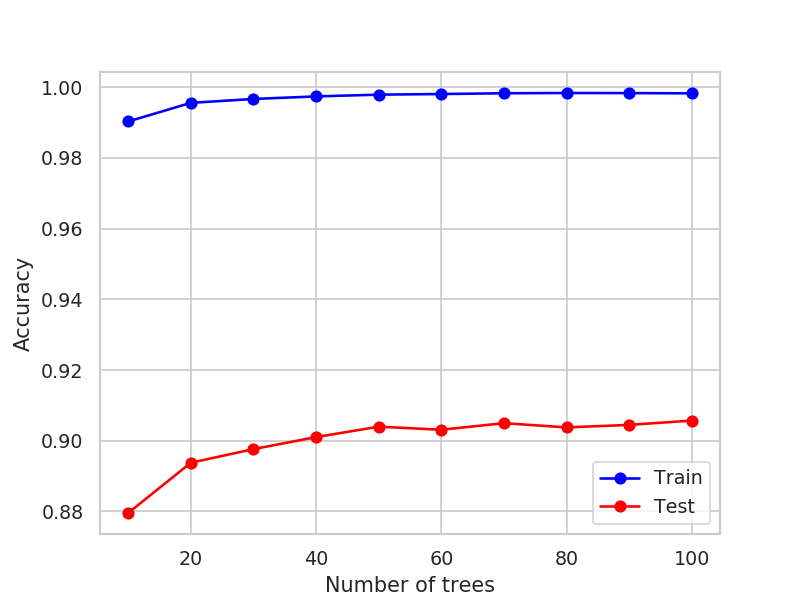

In [44]:
print (clf.score(X_test, y_test))
pd.crosstab( y_test, clf.predict(X_test),normalize = 'index')

# Machine Learning Approach 

## Data cleaning

In [88]:
df_data = df.loc[:,['persons', 'income','race_of_head', 'age_of_head', 
                    'workers','children', 'tenure', 'recent_mover',
                    'sqft_per_unit', 'res_price_per_sqft',
                    'land_value', 'county_id', 'zone_id','tax_exempt_status',
                    'development_type_id', 'cars_alt' ]]

In [89]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    return (data - np.mean(data)) / np.std(data)

to_normalize = ['income', 'age_of_head', 'sqft_per_unit','res_price_per_sqft','land_value', 'workers', 'children', 'tenure' ]

for i in to_normalize:
    df_data[i] = normalize(df_data[[i]])
    

## Decision Tree

In [100]:
from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate

In [113]:
#Splitting the data
x = df_data.drop('cars_alt', axis = 1)
y = df_data.loc[:,'cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

In [155]:
result_train = []
result_test = []
max_depth = range(1,50)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 


<IPython.core.display.Javascript object>


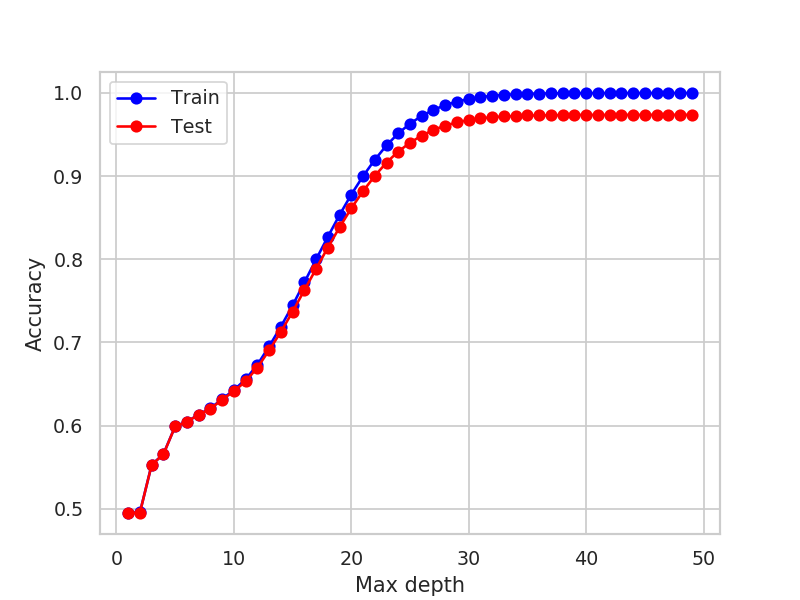

In [156]:
plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()

In [181]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=30)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [182]:
clf.fit(X_train, y_train)
# tree_importance = clf.feature_importances_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

<IPython.core.display.Javascript object>


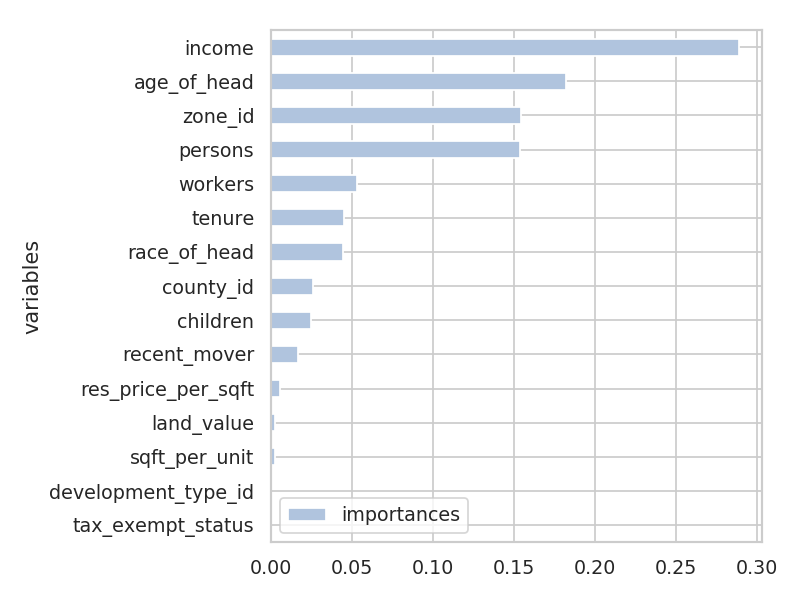

In [183]:
aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks()#(fontsize = 10)
plt.tight_layout()


In [184]:
pd.crosstab( y_test, clf.predict(X_test),normalize = 'index')

col_0,0,1,2,3
cars_alt,,,,
0,0.970837,0.022537,0.005098,0.001528
1,0.004943,0.979949,0.012238,0.002870
2,0.001163,0.009130,0.978063,0.011643
3,0.000566,0.003668,0.029292,0.966474


In [185]:
clf.score(X_test, y_test)

0.9752284268906048

### Random Sampling

<IPython.core.display.Javascript object>


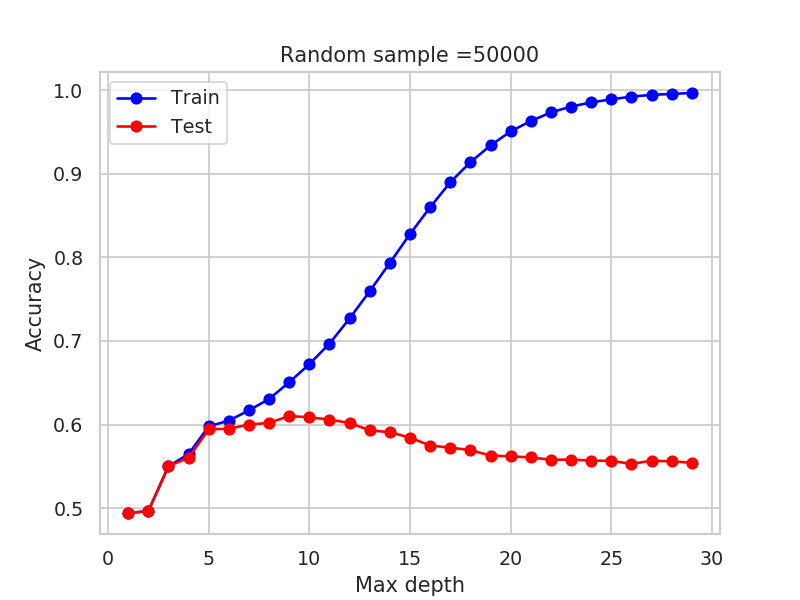

<IPython.core.display.Javascript object>


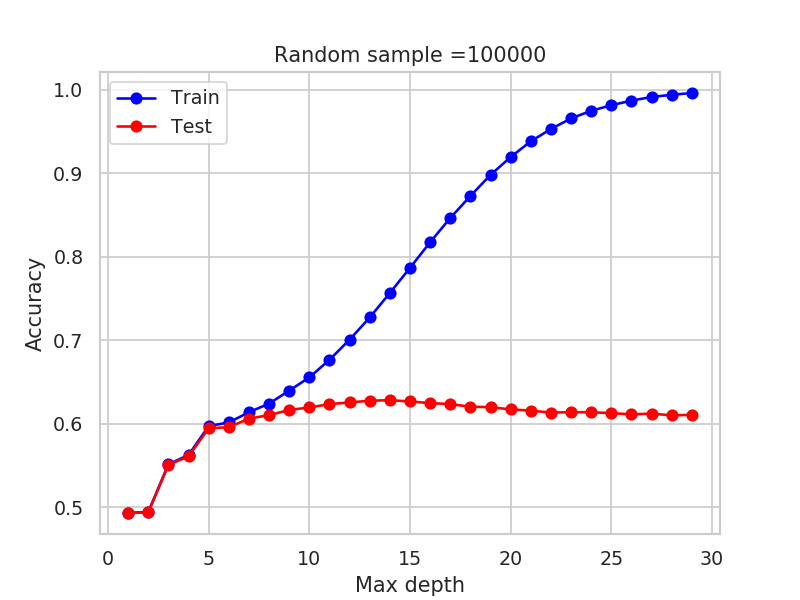

<IPython.core.display.Javascript object>


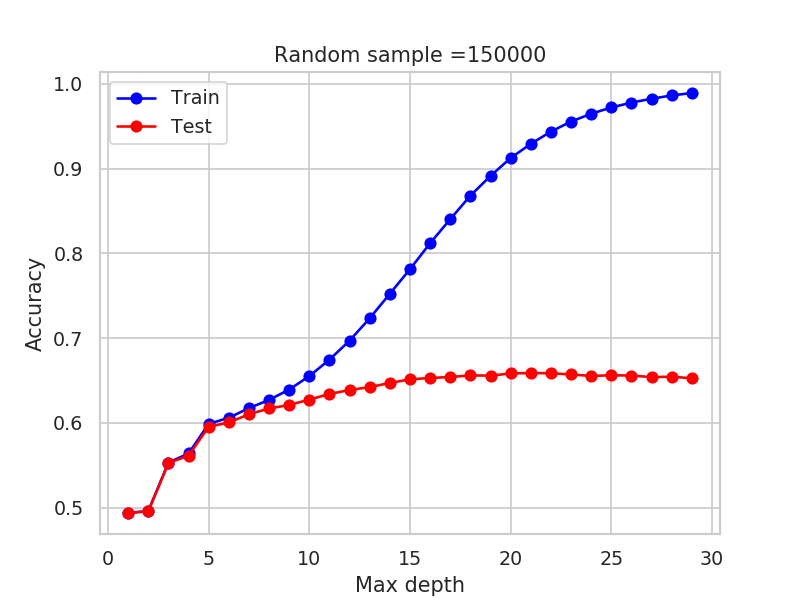

<IPython.core.display.Javascript object>


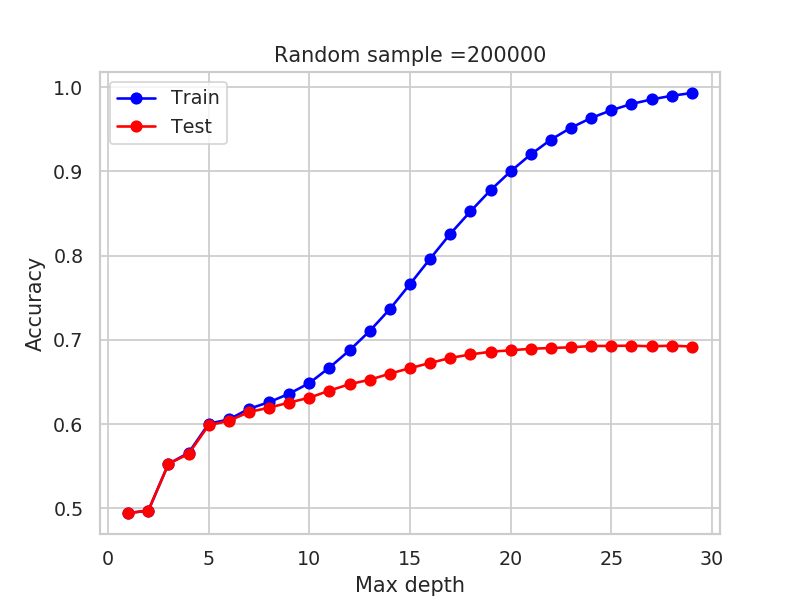

<IPython.core.display.Javascript object>


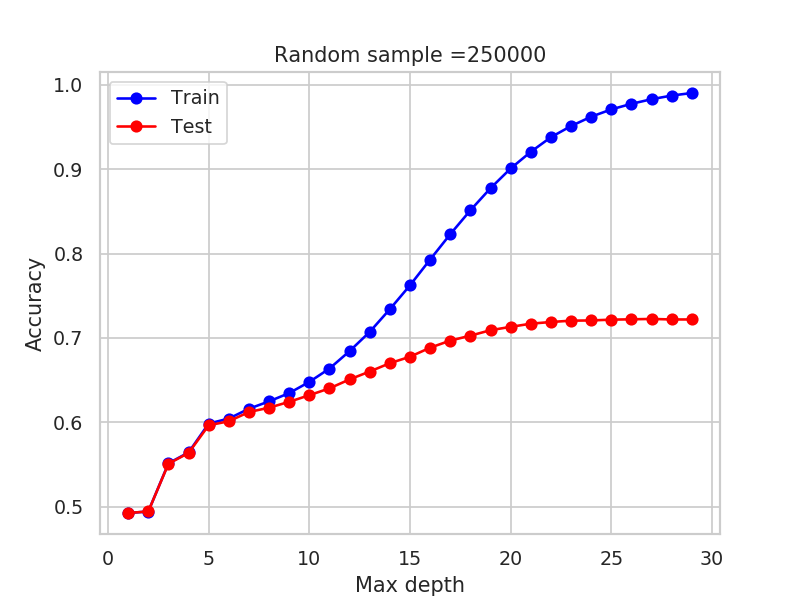

<IPython.core.display.Javascript object>


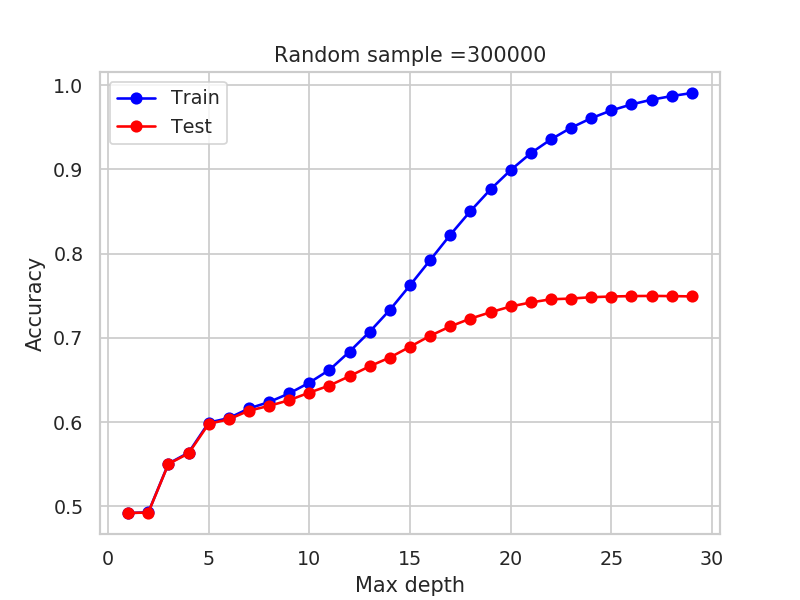

<IPython.core.display.Javascript object>


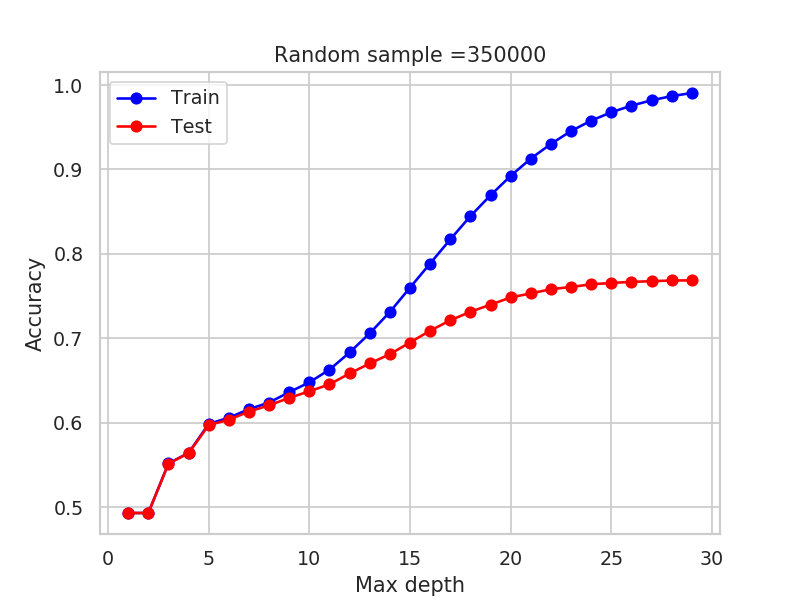

<IPython.core.display.Javascript object>


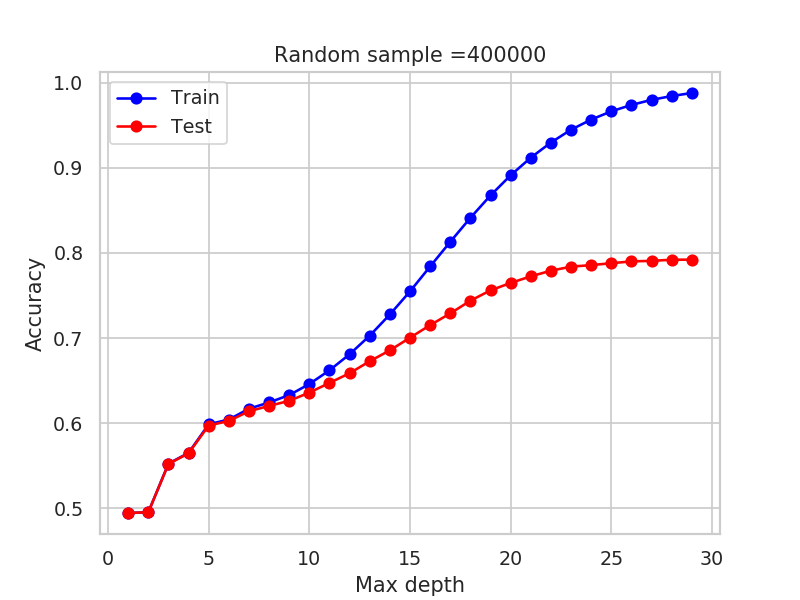

<IPython.core.display.Javascript object>


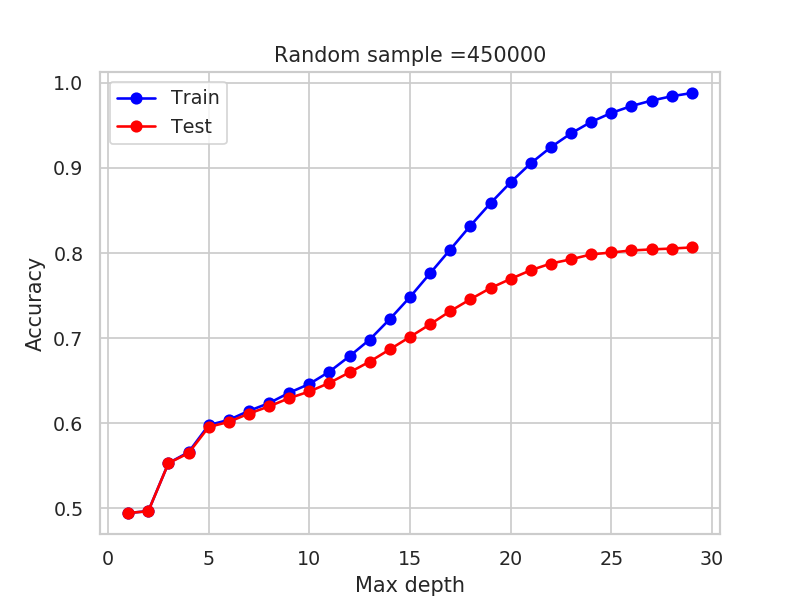

<IPython.core.display.Javascript object>


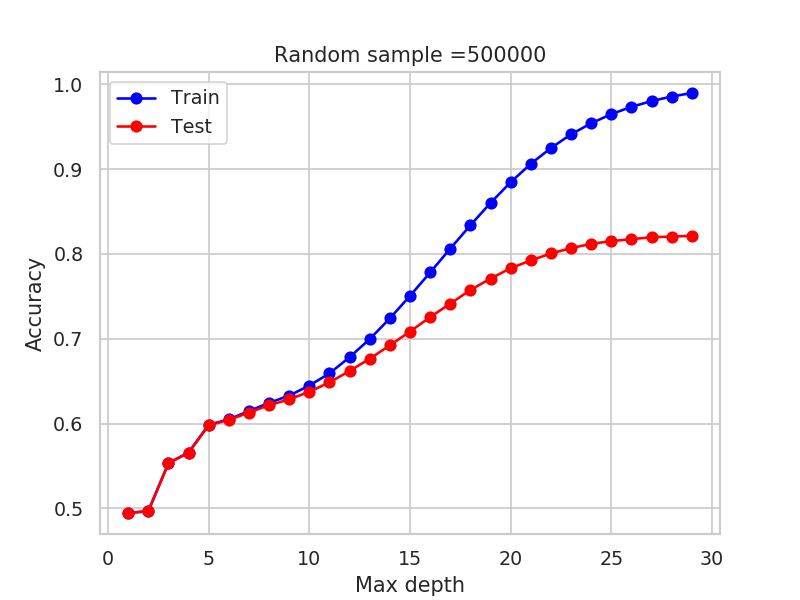

<IPython.core.display.Javascript object>


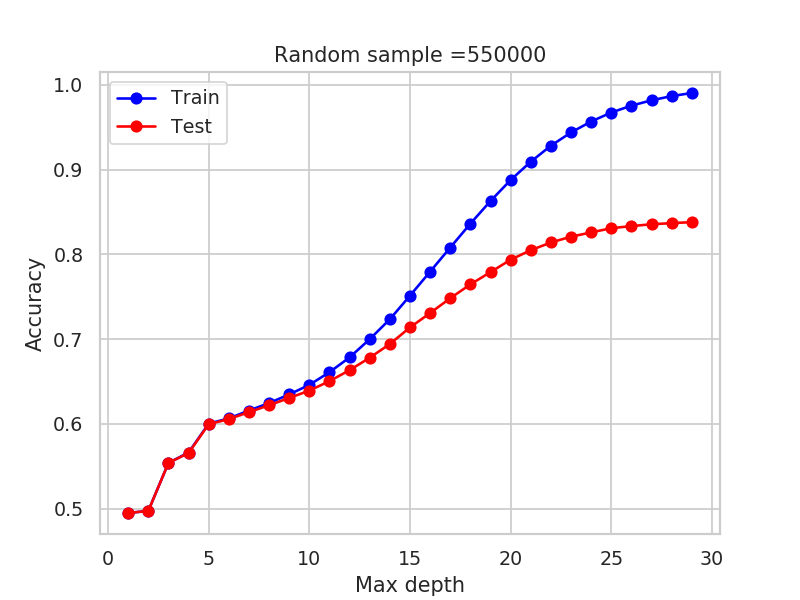

<IPython.core.display.Javascript object>


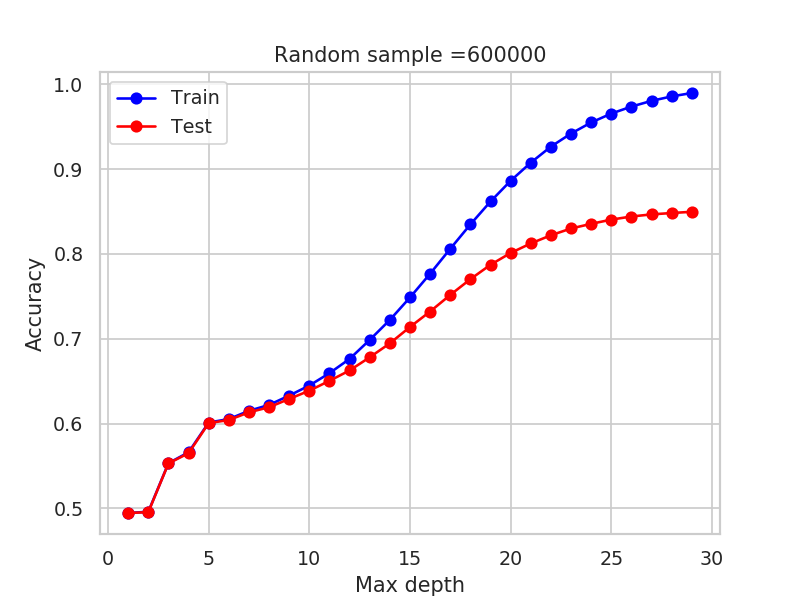

<IPython.core.display.Javascript object>


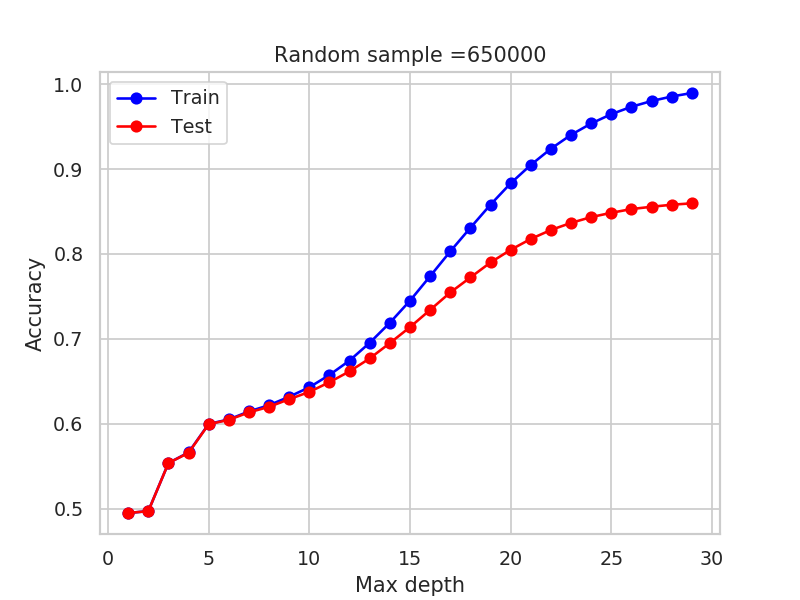

<IPython.core.display.Javascript object>


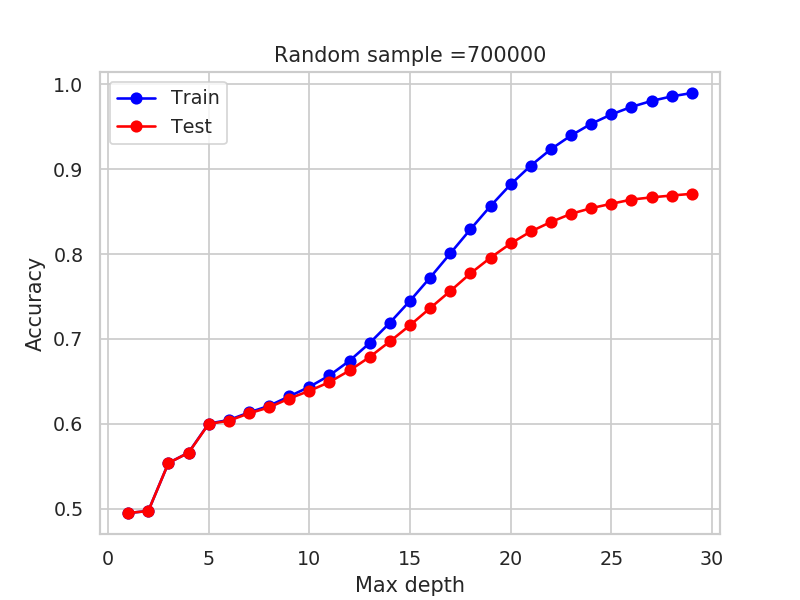

<IPython.core.display.Javascript object>


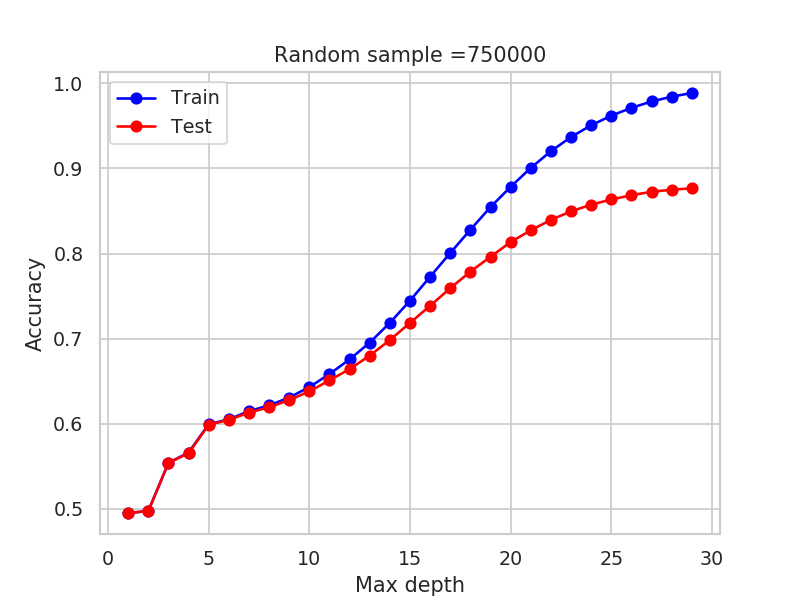

<IPython.core.display.Javascript object>


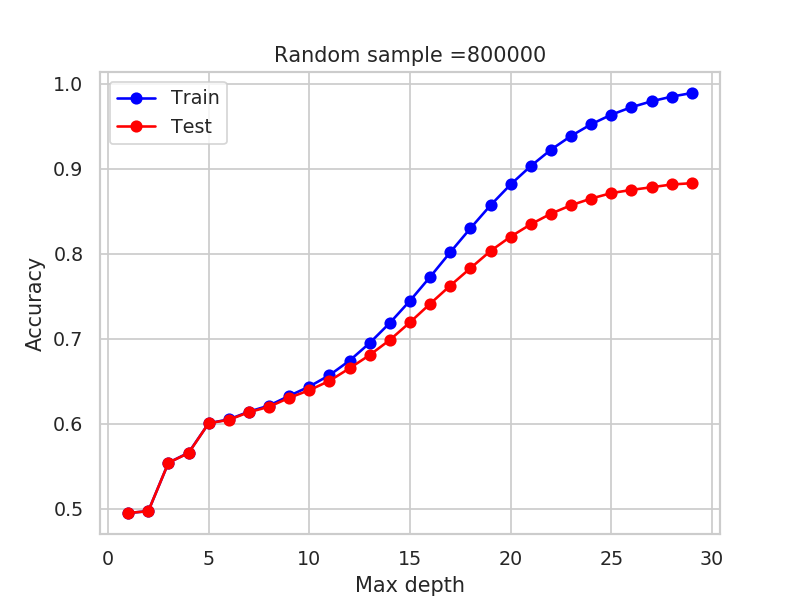

<IPython.core.display.Javascript object>


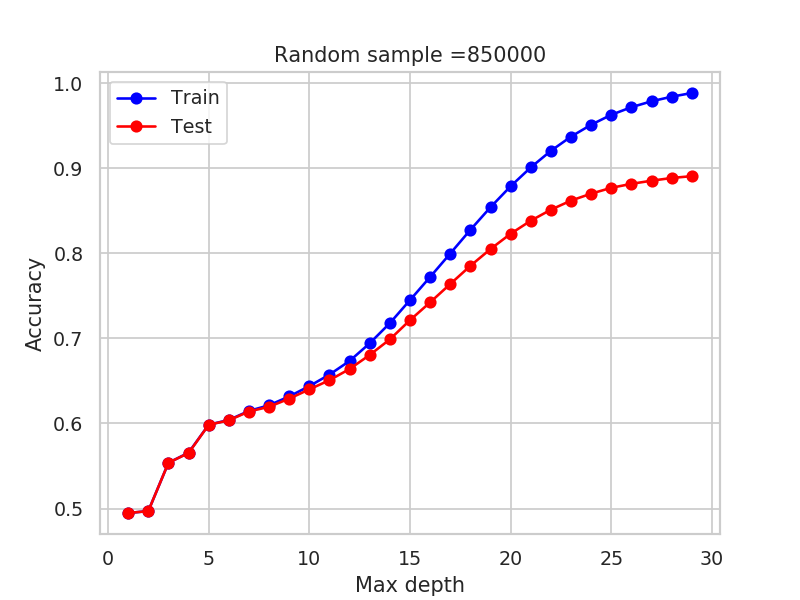

<IPython.core.display.Javascript object>


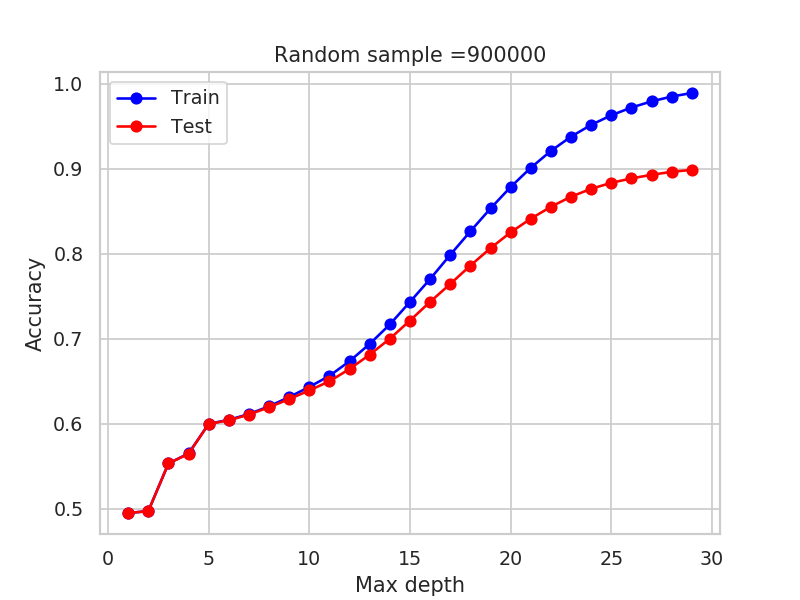

<IPython.core.display.Javascript object>


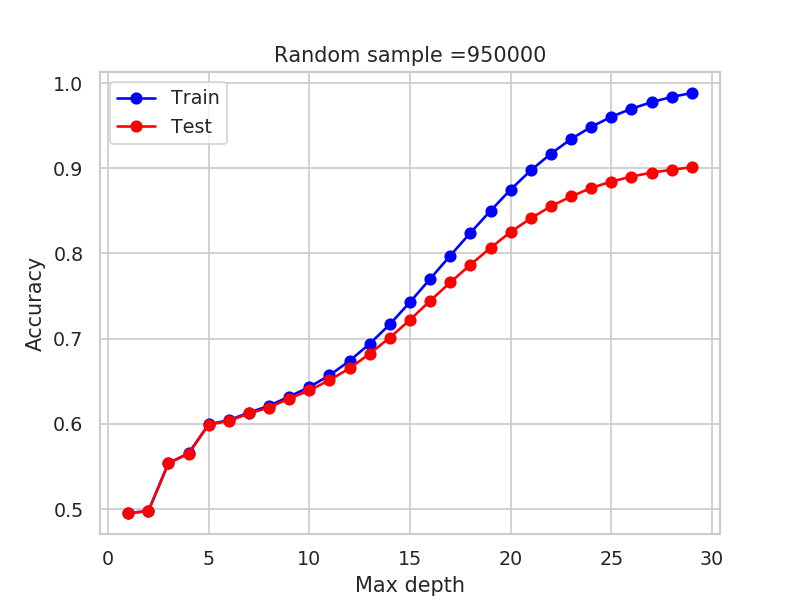

<IPython.core.display.Javascript object>


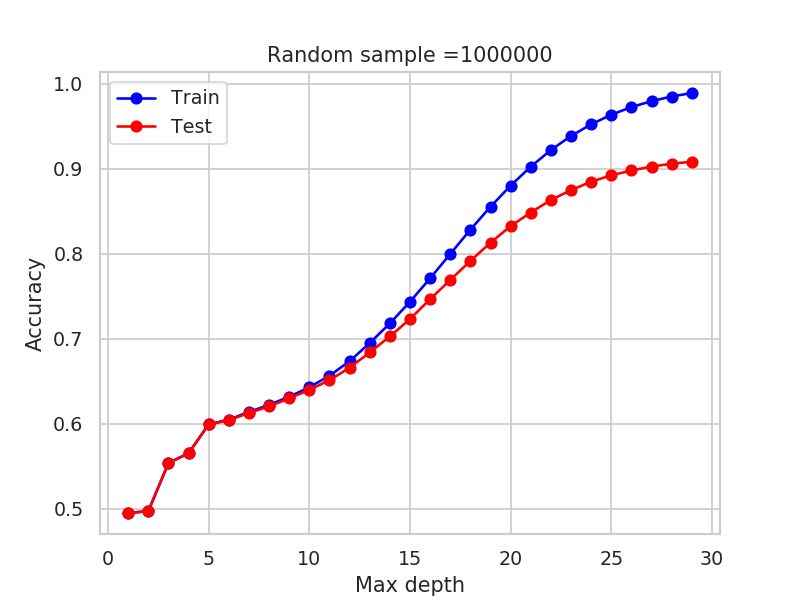

In [203]:
sample_data = range(50000,1000001, 50000)

for j in sample_data:
    df_data_rs = df_data.sample(n=j, random_state= 234)
    x = df_data_rs.drop('cars_alt', axis = 1)
    y = df_data_rs.loc[:,'cars_alt']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)
    
    result_train = []
    result_test = []
    max_depth = range(1,30)
    for i in max_depth:
        clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
        scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
        result_train.append(scores['train_score'].mean())
        result_test.append(scores['test_score'].mean()) 
     
    plt.figure()
    plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
    plt.plot(max_depth, result_test, '-o',color='red',label='Test')
    plt.xlabel('Max depth')
    plt.ylabel('Accuracy')
    plt.title('Random sample =' + str(j))
    plt.legend()

<IPython.core.display.Javascript object>


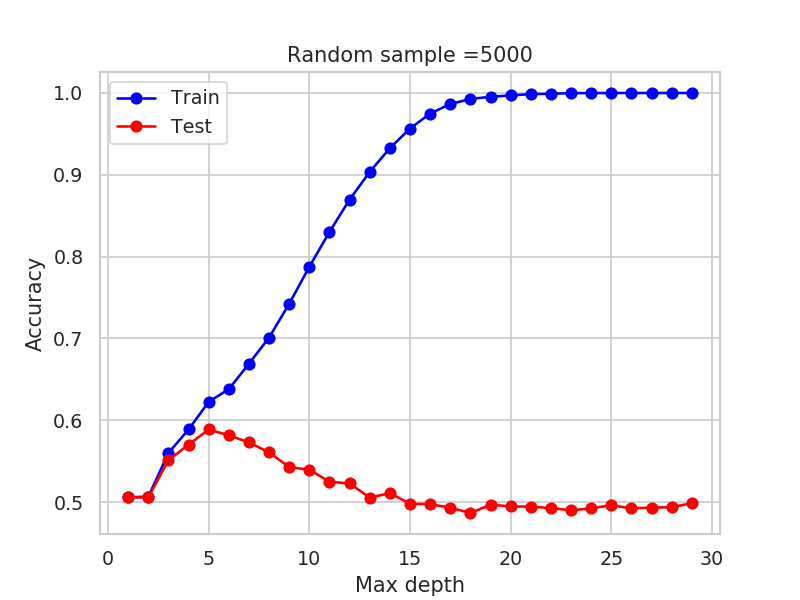

In [215]:

plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Random sample =' + str(trees))
plt.legend()

In [193]:
#Select 50.000 observations randomly
df_data_rs = df_data.sample(n=100000, random_state= 234, )

In [194]:
#Splitting the data
x = df_data_rs.drop('cars_alt', axis = 1)
y = df_data_rs.loc[:,'cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

<IPython.core.display.Javascript object>


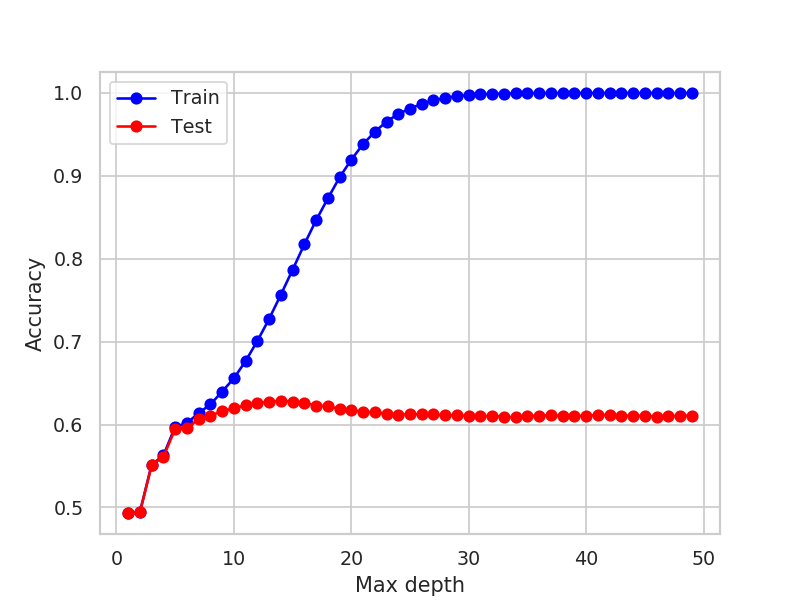

In [195]:
result_train = []
result_test = []
max_depth = range(1,50)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
    
plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()

## Random Forest

In [174]:
from sklearn.ensemble import RandomForestClassifier

In [177]:
# print (clf.score(X_test, y_test))
# pd.crosstab( y_test, clf.predict(X_test),normalize = 'index')

col_0            0         1         2         3
cars_alt                                        
0         0.386697  0.500188  0.090943  0.022172
1         0.053884  0.683865  0.224602  0.037649
2         0.009274  0.196963  0.666968  0.126795
3         0.004067  0.068893  0.414222  0.512817

In [59]:
df_a = pd.DataFrame(
    {'a': [0, 1]},
    index=['a0', 'a1'])
df_b = pd.DataFrame(
    {'b': [2, 3, 4, 5, 6],
     'a_id': ['a0', 'a1', 'a1', 'a0', 'a1']},
    index=['b0', 'b1', 'b2', 'b3', 'b4'])
df_c = pd.DataFrame(
    {'c': [7, 8, 9]},
    index=['c0', 'c1', 'c2'])
df_d = pd.DataFrame(
    {'d': [10, 11, 12, 13, 15, 16, 16, 17, 18, 19],
     'b_id': ['b2', 'b0', 'b3', 'b3', 'b1', 'b4', 'b1', 'b4', 'b3', 'b3'],
     'c_id': ['c0', 'c1', 'c1', 'c0', 'c0', 'c2', 'c1', 'c2', 'c1', 'c2']},
    index=['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9'])

orca.add_table('a', df_a)
orca.add_table('b', df_b)
orca.add_table('c', df_c)
orca.add_table('d', df_d)

In [60]:
orca.broadcast(cast='a', onto='b', cast_index=True, onto_on='a_id')
orca.broadcast(cast='b', onto='d', cast_index=True, onto_on='b_id')
orca.broadcast(cast='c', onto='d', cast_index=True, onto_on='c_id')

# Data 

## Reading & Merging data 

In [122]:
@orca.table(cache=False)
def nodessmall():
    df = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
    df.rename(columns = {'osmid':'node_id_small'}, inplace = True)
    df.set_index('node_id_small',inplace = True)
    return df

@orca.table(cache=False)
def nodeswalk():
    df = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
    df.rename(columns = {'osmid':'node_id_walk'}, inplace = True)
    df.set_index('node_id_walk',inplace = True)
    return df

@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
persons = orca.get_table('persons').to_frame()
parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
nodeswalk = orca.get_table('nodeswalk').to_frame()
am_acc = orca.get_table('am_acc').to_frame()

# # load UrbanAccess transit accessibility variables
# am_acc = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
# am_acc.block_id = am_acc.block_id.str.zfill(15)
# parcels_with_acc = parcels.merge(am_acc, how='left', on='block_id').reindex(index = parcels.index)

# #Creating a county dummy 
# county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
# for i in county_dummies.columns:
#     orca.add_column('parcels',i,county_dummies[i])

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
       'hh_inc_75_to_200k', 'tenure_1', 'tenure_2', 'tenure_3', 'tenure_4',
       'single_family_int', 'building_type_2', 'hh_inc_150kplus',
       'hh_size_1per'],
      dtype='object')

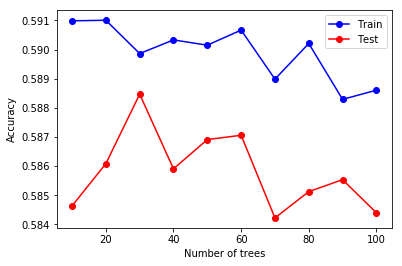

In [148]:
# persons.columns
households.columns

In [149]:
parcels.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk', 'population_60',
       'below_jobs_20', 'below_jobs_60', 'below_jobs_40', 'employment_20',
       'above_jobs_40', 'average_income_20', 'population_20', 'employment_40',
       'population_40', 'employment_60', 'above_jobs_60', 'above_jobs_20',
       'county_1', 'county_13', 'county_41', 'county_55', 'county_75',
       'county_81', 'county_85', 'county_95', 'county_97'],
      dtype='object')

In [146]:
#Broadcasting tables 
orca.broadcast(cast = 'am_acc', onto = 'parcels', cast_on = 'block_id', onto_on = 'block_id')
orca.broadcast(cast = 'persons', onto = 'households', cast_on ='household_id', onto_index = True)

In [150]:
orca.list_broadcasts()

[('parcels', 'buildings'),
 ('buildings', 'units'),
 ('units', 'households'),
 ('households', 'persons'),
 ('buildings', 'jobs'),
 ('buildings', 'establishments'),
 ('nodeswalk', 'parcels'),
 ('nodeswalk', 'rentals'),
 ('nodessmall', 'rentals'),
 ('nodessmall', 'parcels'),
 ('a', 'b'),
 ('b', 'd'),
 ('c', 'd'),
 ('persons', 'households'),
 ('am_acc', 'parcels')]

In [ ]:
# More household varibles from the persons table. 
hh_16_younger = persons[persons['age'] < 16].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_16_younger'})
hh_70_older = persons[persons['age'] > 70].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_70_older'})
hh_students = persons[persons['student'] == 1].groupby(by='household_id').agg({'student':'count'}).rename(columns={'student': 'hh_student'})
hh_work_home = persons[persons['work_at_home'] == 1].groupby(by='household_id').agg({'work_at_home':'count'}).rename(columns={'work_at_home': 'hh_work_home'})

#Mergin new varaibles to the household table 
## CHANGE THIS TO ORCA PIPELINE FLOW
hh_merge = households.merge(hh_16_younger, on = 'household_id',
                           ).merge(hh_70_older, on ='household_id',
                                  ).merge(hh_students, on= 'household_id',
                                         ).merge(hh_work_home, on= 'household_id' )

hh_merge.head(5)

#Example of how to use ORCA flow
# cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
# orca.add_column('households', 'cars_alt', cars_alt)


#Creating the dependent variables 0, 1 ,2 or +3 cars 
hh_merge['cars_alt'] = hh_merge['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

#Impute missing infomration in the parcel/trasint accessibility table 
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [ ]:
#Merging 
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [ ]:
#Final Data set 
df = orca.get_table('hh_merged').to_frame()

## Data cleaning

In [96]:
#Importing data 
df = orca.get_table('households').to_frame()
df_data = df.loc[:,['serialno','persons', 'income','race_of_head','age_of_head', 
                    'workers','children', 'tenure','cars_alt']]

In [97]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    return (data - np.mean(data)) / np.std(data)

to_normalize = ['income', 'age_of_head', 'workers', 'children', 'tenure' ]

for i in to_normalize:
    df_data[i] = normalize(df_data[[i]])

In [223]:
#Training and test index
import random
index_list = df.serialno.unique()

#Filling transit accessibility NA 
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('primary_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('primary_id')


#Merging parcels onto household
df_merge = household_chts.merge(parcels_acc, how = 'left', left_on ='parcel_id_home', right_index= True )

df_merge = df_merge[df_merge.INCOM<50]

In [32]:
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [224]:
hh_merge = households.merge(hh_16_younger, on = 'household_id',
                           ).merge(hh_70_older, on ='household_id',
                                  ).merge(hh_students, on= 'household_id',
                                         ).merge(hh_work_home, on= 'household_id' )

hh_merge.head(5)

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       ...
       'hh_25000', 'poor_25000', 'renters_25000', 'med_income_25000',
       'jobs_25000', 'med_rent_25000', 'pop_white_25000', 'pop_black_25000',
       'pop_asian_25000', 'pop_hisp_25000'],
      dtype='object', length=219)

In [47]:
hh_merge['cars_alt'] = hh_merge['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

In [48]:
hh_merge.head(5)

,serialno,persons,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,state,...,tenure_4,single_family_int,building_type_2,hh_inc_150kplus,hh_size_1per,hh_16_younger,hh_70_older,hh_student,hh_work_home,cars_alt
household_id,,,,,,,,,,,,,,,,,,,,,
14127,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
17257,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
24020,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
28196,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
33517,2013000084437,5.0,8.0,3.0,75700.0,1,no,71,4.0,6,...,0,0,0,0,0,1,1,3,2,3


In [22]:
# cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
# orca.add_column('households', 'cars_alt', cars_alt)

In [23]:
# # income bins
# income_bins = pd.cut(orca.get_table('households').to_frame().income,
#       bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
#       labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
# income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
# for i in income_bin_dummies.columns:
#     orca.add_column('households',i,income_bin_dummies[i])

# # tenure type dummy
# orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
# orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
# orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
# orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# # single family as integer
# orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# # building type dummy
# orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))

In [56]:
parcels = orca.get_table('parcels').to_frame()

In [70]:
os.listdir("/home/data/urbanaccess_transit")

['access_indicators_latenight.csv',
 'access_indicators_pmpeak.csv',
 'access_indicators_noon.csv',
 'access_indicators_ampeak.csv']

In [57]:
# load UrbanAccess transit accessibility variables
am_acc = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
am_acc.block_id = am_acc.block_id.str.zfill(15)
parcels_with_acc = parcels.merge(am_acc, how='left', on='block_id').reindex(index = parcels.index) # reorder to align with parcels table

In [77]:
parcels.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk'],
      dtype='object')

In [72]:
am_acc.columns

Index(['block_id', 'above_jobs_20', 'above_jobs_40', 'above_jobs_60',
       'average_income_20', 'below_jobs_20', 'below_jobs_40', 'below_jobs_60',
       'employment_20', 'employment_40', 'employment_60', 'population_20',
       'population_40', 'population_60'],
      dtype='object')

In [58]:
parcels_with_acc.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk', 'above_jobs_20',
       'above_jobs_40', 'above_jobs_60', 'average_income_20', 'below_jobs_20',
       'below_jobs_40', 'below_jobs_60', 'employment_20', 'employment_40',
       'employment_60', 'population_20', 'population_40', 'population_60'],
      dtype='object')

In [80]:
parcels_with_acc.shape

(1956207, 31)

In [81]:
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [91]:
nodessmall = orca.get_table('nodessmall').to_frame()
nodessmall.columns

Index(['units_10000', 'units_sf_10000', 'units_mf_10000', 'pop_10000',
       'hh_10000', 'poor_10000', 'renters_10000', 'med_income_10000',
       'jobs_10000', 'med_rent_10000', 'pop_white_10000', 'pop_black_10000',
       'pop_asian_10000', 'pop_hisp_10000', 'units_25000', 'units_sf_25000',
       'units_mf_25000', 'pop_25000', 'hh_25000', 'poor_25000',
       'renters_25000', 'med_income_25000', 'jobs_25000', 'med_rent_25000',
       'pop_white_25000', 'pop_black_25000', 'pop_asian_25000',
       'pop_hisp_25000'],
      dtype='object')

In [96]:
nodeswalk = orca.get_table('nodeswalk').to_frame()
nodeswalk.columns

Index(['units_500_walk', 'sqft_unit_500_walk', 'singles_500_walk',
       'elderly_hh_500_walk', 'children_500_walk', 'units_sf_500_walk',
       'units_mf_500_walk', 'pop_500_walk', 'hh_500_walk', 'poor_500_walk',
       'rich_500_walk', 'renters_500_walk', 'avg_income_500_walk',
       'jobs_500_walk', 'avg_rent_500_walk', 'pop_white_500_walk',
       'pop_black_500_walk', 'pop_asian_500_walk', 'pop_hisp_500_walk',
       'units_1500_walk', 'sqft_unit_1500_walk', 'singles_1500_walk',
       'elderly_hh_1500_walk', 'children_1500_walk', 'units_sf_1500_walk',
       'units_mf_1500_walk', 'pop_1500_walk', 'hh_1500_walk', 'poor_1500_walk',
       'rich_1500_walk', 'renters_1500_walk', 'avg_income_1500_walk',
       'jobs_1500_walk', 'avg_rent_1500_walk', 'pop_white_1500_walk',
       'pop_black_1500_walk', 'pop_asian_1500_walk', 'pop_hisp_1500_walk',
       'pop_2500_walk', 'pop_white_2500_walk', 'pop_black_2500_walk',
       'pop_asian_2500_walk', 'pop_hisp_2500_walk', 'prop_children_50

In [84]:
county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
for i in county_dummies.columns:
    orca.add_column('parcels',i,county_dummies[i])

In [97]:
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [99]:


acc_cols = list(orca.get_table('nodessmall').to_frame().columns) + list(orca.get_table('nodeswalk').to_frame().columns) + list(set(parcels_with_acc.columns) - set(parcels))

df = orca.get_table('hh_merged').to_frame()
df.shape

(2487699, 185)

In [ ]:
#Exclude
'serialno', 'cars',  'tract', 'block_group'

#Binary Choices
'hispanic_head','recent_mover', 'single_family'

#Continous
'building_type', 'income', 'race_of_head', 'age_of_head', 'workers','county', 'children', 'tenure',

In [108]:
df['cars_alt'] = df['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

In [112]:
df.columns[:100] 

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
       'hh_inc_75_to_200k', 'tenure_1', 'tenure_2', 'tenure_3', 'tenure_4',
       'single_family_int', 'building_type_2', 'hh_inc_150kplus',
       'hh_size_1per', 'num_units', 'unit_num', 'unit_residential_price',
       'unit_residential_rent', 'parcel_id', 'development_type_id',
       'improvement_value', 'residential_units', 'residential_sqft',
       'sqft_per_unit', 'non_residential_sqft', 'building_sqft',
       'nonres_rent_per_sqft', 'res_price_per_sqft', 'stories', 'year_built',
       'redfin_sale_price', 'redfin_sale_year', 'redfin_home_type',
       'costar_property_type', 'costar_rent', 'building_type_id',
   

In [14]:
#Defining a set of Variables for the model 


In [15]:
X = df.drop(labels = 'cars_alt', axis =1)
y = df['cars_alt']

In [ ]:
# sample_size = 100000
# df_data_jayne = df.sample(n= sample_size, random_state= 234)
# x = df_data_jayne.drop(labels = 'cars_alt', axis =1)
# y = df_data_jayne['cars_alt']
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)
    
# result_train = []
# result_test = []
# max_depth = range(1,30)
# for i in max_depth:
#     clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
#     scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
#     result_train.append(scores['train_score'].mean())
#     result_test.append(scores['test_score'].mean()) 
     
# plt.figure()
# plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
# plt.plot(max_depth, result_test, '-o',color='red',label='Test')
# plt.xlabel('Max depth')
# plt.ylabel('Accuracy')
# plt.title('Random sample =' + str(sample_size))
# plt.legend()

In [ ]:
# clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=8)
# clf.fit(X_train, y_train)

# aa = pd.DataFrame({'importances':clf.feature_importances_,
#                    'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

# aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue', figsize =(5,15) )
# plt.yticks()#(fontsize = 10)
# plt.tight_layout()

In [243]:
# print (clf.score(X_test, y_test))
# pd.crosstab( y_test, clf.predict(X_test),normalize = 'index')

0.6116060606060606


col_0,0,1,2,3
cars_alt,,,,
0,0.386697,0.500188,0.090943,0.022172
1,0.053884,0.683865,0.224602,0.037649
2,0.009274,0.196963,0.666968,0.126795
3,0.004067,0.068893,0.414222,0.512817


In [59]:
df_a = pd.DataFrame(
    {'a': [0, 1]},
    index=['a0', 'a1'])
df_b = pd.DataFrame(
    {'b': [2, 3, 4, 5, 6],
     'a_id': ['a0', 'a1', 'a1', 'a0', 'a1']},
    index=['b0', 'b1', 'b2', 'b3', 'b4'])
df_c = pd.DataFrame(
    {'c': [7, 8, 9]},
    index=['c0', 'c1', 'c2'])
df_d = pd.DataFrame(
    {'d': [10, 11, 12, 13, 15, 16, 16, 17, 18, 19],
     'b_id': ['b2', 'b0', 'b3', 'b3', 'b1', 'b4', 'b1', 'b4', 'b3', 'b3'],
     'c_id': ['c0', 'c1', 'c1', 'c0', 'c0', 'c2', 'c1', 'c2', 'c1', 'c2']},
    index=['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9'])

orca.add_table('a', df_a)
orca.add_table('b', df_b)
orca.add_table('c', df_c)
orca.add_table('d', df_d)

In [60]:
orca.broadcast(cast='a', onto='b', cast_index=True, onto_on='a_id')
orca.broadcast(cast='b', onto='d', cast_index=True, onto_on='b_id')
orca.broadcast(cast='c', onto='d', cast_index=True, onto_on='c_id')

# Data 

## Reading & Merging data 

In [122]:
@orca.table(cache=False)
def nodessmall():
    df = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
    df.rename(columns = {'osmid':'node_id_small'}, inplace = True)
    df.set_index('node_id_small',inplace = True)
    return df

@orca.table(cache=False)
def nodeswalk():
    df = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
    df.rename(columns = {'osmid':'node_id_walk'}, inplace = True)
    df.set_index('node_id_walk',inplace = True)
    return df

@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
persons = orca.get_table('persons').to_frame()
parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
nodeswalk = orca.get_table('nodeswalk').to_frame()
am_acc = orca.get_table('am_acc').to_frame()

# # load UrbanAccess transit accessibility variables
# am_acc = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
# am_acc.block_id = am_acc.block_id.str.zfill(15)
# parcels_with_acc = parcels.merge(am_acc, how='left', on='block_id').reindex(index = parcels.index)

# #Creating a county dummy 
# county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
# for i in county_dummies.columns:
#     orca.add_column('parcels',i,county_dummies[i])

In [148]:
# persons.columns
households.columns

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
       'hh_inc_75_to_200k', 'tenure_1', 'tenure_2', 'tenure_3', 'tenure_4',
       'single_family_int', 'building_type_2', 'hh_inc_150kplus',
       'hh_size_1per'],
      dtype='object')

In [149]:
parcels.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk', 'population_60',
       'below_jobs_20', 'below_jobs_60', 'below_jobs_40', 'employment_20',
       'above_jobs_40', 'average_income_20', 'population_20', 'employment_40',
       'population_40', 'employment_60', 'above_jobs_60', 'above_jobs_20',
       'county_1', 'county_13', 'county_41', 'county_55', 'county_75',
       'county_81', 'county_85', 'county_95', 'county_97'],
      dtype='object')

In [146]:
#Broadcasting tables 
orca.broadcast(cast = 'am_acc', onto = 'parcels', cast_on = 'block_id', onto_on = 'block_id')
orca.broadcast(cast = 'persons', onto = 'households', cast_on ='household_id', onto_index = True)

In [150]:
orca.list_broadcasts()

[('parcels', 'buildings'),
 ('buildings', 'units'),
 ('units', 'households'),
 ('households', 'persons'),
 ('buildings', 'jobs'),
 ('buildings', 'establishments'),
 ('nodeswalk', 'parcels'),
 ('nodeswalk', 'rentals'),
 ('nodessmall', 'rentals'),
 ('nodessmall', 'parcels'),
 ('a', 'b'),
 ('b', 'd'),
 ('c', 'd'),
 ('persons', 'households'),
 ('am_acc', 'parcels')]

In [ ]:
# More household varibles from the persons table. 
hh_16_younger = persons[persons['age'] < 16].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_16_younger'})
hh_70_older = persons[persons['age'] > 70].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_70_older'})
hh_students = persons[persons['student'] == 1].groupby(by='household_id').agg({'student':'count'}).rename(columns={'student': 'hh_student'})
hh_work_home = persons[persons['work_at_home'] == 1].groupby(by='household_id').agg({'work_at_home':'count'}).rename(columns={'work_at_home': 'hh_work_home'})

#Mergin new varaibles to the household table 
## CHANGE THIS TO ORCA PIPELINE FLOW
hh_merge = households.merge(hh_16_younger, on = 'household_id',
                           ).merge(hh_70_older, on ='household_id',
                                  ).merge(hh_students, on= 'household_id',
                                         ).merge(hh_work_home, on= 'household_id' )

hh_merge.head(5)

#Example of how to use ORCA flow
# cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
# orca.add_column('households', 'cars_alt', cars_alt)


#Creating the dependent variables 0, 1 ,2 or +3 cars 
hh_merge['cars_alt'] = hh_merge['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

#Impute missing infomration in the parcel/trasint accessibility table 
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [ ]:
#Merging 
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [ ]:
#Final Data set 
df = orca.get_table('hh_merged').to_frame()

## Data cleaning

In [96]:
#Importing data 
df = orca.get_table('households').to_frame()
df_data = df.loc[:,['serialno','persons', 'income','race_of_head','age_of_head', 
                    'workers','children', 'tenure','cars_alt']]

In [97]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    return (data - np.mean(data)) / np.std(data)

to_normalize = ['income', 'age_of_head', 'workers', 'children', 'tenure' ]

for i in to_normalize:
    df_data[i] = normalize(df_data[[i]])

In [223]:
#Training and test index
import random
index_list = df.serialno.unique()

#Filling transit accessibility NA 
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('primary_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('primary_id')


#Merging parcels onto household
df_merge = household_chts.merge(parcels_acc, how = 'left', left_on ='parcel_id_home', right_index= True )

df_merge = df_merge[df_merge.INCOM<50]

In [32]:
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [224]:
hh_merge = households.merge(hh_16_younger, on = 'household_id',
                           ).merge(hh_70_older, on ='household_id',
                                  ).merge(hh_students, on= 'household_id',
                                         ).merge(hh_work_home, on= 'household_id' )

hh_merge.head(5)

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       ...
       'hh_25000', 'poor_25000', 'renters_25000', 'med_income_25000',
       'jobs_25000', 'med_rent_25000', 'pop_white_25000', 'pop_black_25000',
       'pop_asian_25000', 'pop_hisp_25000'],
      dtype='object', length=219)

In [47]:
hh_merge['cars_alt'] = hh_merge['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

In [48]:
hh_merge.head(5)

,serialno,persons,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,state,...,tenure_4,single_family_int,building_type_2,hh_inc_150kplus,hh_size_1per,hh_16_younger,hh_70_older,hh_student,hh_work_home,cars_alt
household_id,,,,,,,,,,,,,,,,,,,,,
14127,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
17257,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
24020,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
28196,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
33517,2013000084437,5.0,8.0,3.0,75700.0,1,no,71,4.0,6,...,0,0,0,0,0,1,1,3,2,3


In [22]:
# cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
# orca.add_column('households', 'cars_alt', cars_alt)

In [23]:
# # income bins
# income_bins = pd.cut(orca.get_table('households').to_frame().income,
#       bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
#       labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
# income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
# for i in income_bin_dummies.columns:
#     orca.add_column('households',i,income_bin_dummies[i])

# # tenure type dummy
# orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
# orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
# orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
# orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# # single family as integer
# orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# # building type dummy
# orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))

In [56]:
parcels = orca.get_table('parcels').to_frame()

In [70]:
os.listdir("/home/data/urbanaccess_transit")

['access_indicators_latenight.csv',
 'access_indicators_pmpeak.csv',
 'access_indicators_noon.csv',
 'access_indicators_ampeak.csv']

In [57]:
# load UrbanAccess transit accessibility variables
am_acc = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
am_acc.block_id = am_acc.block_id.str.zfill(15)
parcels_with_acc = parcels.merge(am_acc, how='left', on='block_id').reindex(index = parcels.index) # reorder to align with parcels table

In [77]:
parcels.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk'],
      dtype='object')

In [72]:
am_acc.columns

Index(['block_id', 'above_jobs_20', 'above_jobs_40', 'above_jobs_60',
       'average_income_20', 'below_jobs_20', 'below_jobs_40', 'below_jobs_60',
       'employment_20', 'employment_40', 'employment_60', 'population_20',
       'population_40', 'population_60'],
      dtype='object')

In [58]:
parcels_with_acc.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk', 'above_jobs_20',
       'above_jobs_40', 'above_jobs_60', 'average_income_20', 'below_jobs_20',
       'below_jobs_40', 'below_jobs_60', 'employment_20', 'employment_40',
       'employment_60', 'population_20', 'population_40', 'population_60'],
      dtype='object')

In [80]:
parcels_with_acc.shape

(1956207, 31)

In [81]:
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [91]:
nodessmall = orca.get_table('nodessmall').to_frame()
nodessmall.columns

Index(['units_10000', 'units_sf_10000', 'units_mf_10000', 'pop_10000',
       'hh_10000', 'poor_10000', 'renters_10000', 'med_income_10000',
       'jobs_10000', 'med_rent_10000', 'pop_white_10000', 'pop_black_10000',
       'pop_asian_10000', 'pop_hisp_10000', 'units_25000', 'units_sf_25000',
       'units_mf_25000', 'pop_25000', 'hh_25000', 'poor_25000',
       'renters_25000', 'med_income_25000', 'jobs_25000', 'med_rent_25000',
       'pop_white_25000', 'pop_black_25000', 'pop_asian_25000',
       'pop_hisp_25000'],
      dtype='object')

In [96]:
nodeswalk = orca.get_table('nodeswalk').to_frame()
nodeswalk.columns

Index(['units_500_walk', 'sqft_unit_500_walk', 'singles_500_walk',
       'elderly_hh_500_walk', 'children_500_walk', 'units_sf_500_walk',
       'units_mf_500_walk', 'pop_500_walk', 'hh_500_walk', 'poor_500_walk',
       'rich_500_walk', 'renters_500_walk', 'avg_income_500_walk',
       'jobs_500_walk', 'avg_rent_500_walk', 'pop_white_500_walk',
       'pop_black_500_walk', 'pop_asian_500_walk', 'pop_hisp_500_walk',
       'units_1500_walk', 'sqft_unit_1500_walk', 'singles_1500_walk',
       'elderly_hh_1500_walk', 'children_1500_walk', 'units_sf_1500_walk',
       'units_mf_1500_walk', 'pop_1500_walk', 'hh_1500_walk', 'poor_1500_walk',
       'rich_1500_walk', 'renters_1500_walk', 'avg_income_1500_walk',
       'jobs_1500_walk', 'avg_rent_1500_walk', 'pop_white_1500_walk',
       'pop_black_1500_walk', 'pop_asian_1500_walk', 'pop_hisp_1500_walk',
       'pop_2500_walk', 'pop_white_2500_walk', 'pop_black_2500_walk',
       'pop_asian_2500_walk', 'pop_hisp_2500_walk', 'prop_children_50

In [84]:
county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
for i in county_dummies.columns:
    orca.add_column('parcels',i,county_dummies[i])

In [97]:
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [99]:


acc_cols = list(orca.get_table('nodessmall').to_frame().columns) + list(orca.get_table('nodeswalk').to_frame().columns) + list(set(parcels_with_acc.columns) - set(parcels))

df = orca.get_table('hh_merged').to_frame()
df.shape

(2487699, 185)

In [ ]:
#Exclude
'serialno', 'cars',  'tract', 'block_group'

#Binary Choices
'hispanic_head','recent_mover', 'single_family'

#Continous
'building_type', 'income', 'race_of_head', 'age_of_head', 'workers','county', 'children', 'tenure',

In [108]:
df['cars_alt'] = df['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

In [112]:
df.columns[:100] 

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
       'hh_inc_75_to_200k', 'tenure_1', 'tenure_2', 'tenure_3', 'tenure_4',
       'single_family_int', 'building_type_2', 'hh_inc_150kplus',
       'hh_size_1per', 'num_units', 'unit_num', 'unit_residential_price',
       'unit_residential_rent', 'parcel_id', 'development_type_id',
       'improvement_value', 'residential_units', 'residential_sqft',
       'sqft_per_unit', 'non_residential_sqft', 'building_sqft',
       'nonres_rent_per_sqft', 'res_price_per_sqft', 'stories', 'year_built',
       'redfin_sale_price', 'redfin_sale_year', 'redfin_home_type',
       'costar_property_type', 'costar_rent', 'building_type_id',
   

In [14]:
#Defining a set of Variables for the model 


In [15]:
X = df.drop(labels = 'cars_alt', axis =1)
y = df['cars_alt']

In [ ]:
# sample_size = 100000
# df_data_jayne = df.sample(n= sample_size, random_state= 234)
# x = df_data_jayne.drop(labels = 'cars_alt', axis =1)
# y = df_data_jayne['cars_alt']
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)
    
# result_train = []
# result_test = []
# max_depth = range(1,30)
# for i in max_depth:
#     clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
#     scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
#     result_train.append(scores['train_score'].mean())
#     result_test.append(scores['test_score'].mean()) 
     
# plt.figure()
# plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
# plt.plot(max_depth, result_test, '-o',color='red',label='Test')
# plt.xlabel('Max depth')
# plt.ylabel('Accuracy')
# plt.title('Random sample =' + str(sample_size))
# plt.legend()

In [ ]:
# clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=8)
# clf.fit(X_train, y_train)

# aa = pd.DataFrame({'importances':clf.feature_importances_,
#                    'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

# aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue', figsize =(5,15) )
# plt.yticks()#(fontsize = 10)
# plt.tight_layout()

In [243]:
# print (clf.score(X_test, y_test))
# pd.crosstab( y_test, clf.predict(X_test),normalize = 'index')

0.6116060606060606


col_0,0,1,2,3
cars_alt,,,,
0,0.386697,0.500188,0.090943,0.022172
1,0.053884,0.683865,0.224602,0.037649
2,0.009274,0.196963,0.666968,0.126795
3,0.004067,0.068893,0.414222,0.512817


In [59]:
df_a = pd.DataFrame(
    {'a': [0, 1]},
    index=['a0', 'a1'])
df_b = pd.DataFrame(
    {'b': [2, 3, 4, 5, 6],
     'a_id': ['a0', 'a1', 'a1', 'a0', 'a1']},
    index=['b0', 'b1', 'b2', 'b3', 'b4'])
df_c = pd.DataFrame(
    {'c': [7, 8, 9]},
    index=['c0', 'c1', 'c2'])
df_d = pd.DataFrame(
    {'d': [10, 11, 12, 13, 15, 16, 16, 17, 18, 19],
     'b_id': ['b2', 'b0', 'b3', 'b3', 'b1', 'b4', 'b1', 'b4', 'b3', 'b3'],
     'c_id': ['c0', 'c1', 'c1', 'c0', 'c0', 'c2', 'c1', 'c2', 'c1', 'c2']},
    index=['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9'])

orca.add_table('a', df_a)
orca.add_table('b', df_b)
orca.add_table('c', df_c)
orca.add_table('d', df_d)

In [60]:
orca.broadcast(cast='a', onto='b', cast_index=True, onto_on='a_id')
orca.broadcast(cast='b', onto='d', cast_index=True, onto_on='b_id')
orca.broadcast(cast='c', onto='d', cast_index=True, onto_on='c_id')

# Data 

## Reading & Merging data 

In [122]:
@orca.table(cache=False)
def nodessmall():
    df = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
    df.rename(columns = {'osmid':'node_id_small'}, inplace = True)
    df.set_index('node_id_small',inplace = True)
    return df

@orca.table(cache=False)
def nodeswalk():
    df = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
    df.rename(columns = {'osmid':'node_id_walk'}, inplace = True)
    df.set_index('node_id_walk',inplace = True)
    return df

@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
persons = orca.get_table('persons').to_frame()
parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
nodeswalk = orca.get_table('nodeswalk').to_frame()
am_acc = orca.get_table('am_acc').to_frame()

# # load UrbanAccess transit accessibility variables
# am_acc = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
# am_acc.block_id = am_acc.block_id.str.zfill(15)
# parcels_with_acc = parcels.merge(am_acc, how='left', on='block_id').reindex(index = parcels.index)

# #Creating a county dummy 
# county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
# for i in county_dummies.columns:
#     orca.add_column('parcels',i,county_dummies[i])

In [148]:
# persons.columns
households.columns

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
       'hh_inc_75_to_200k', 'tenure_1', 'tenure_2', 'tenure_3', 'tenure_4',
       'single_family_int', 'building_type_2', 'hh_inc_150kplus',
       'hh_size_1per'],
      dtype='object')

In [149]:
parcels.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk', 'population_60',
       'below_jobs_20', 'below_jobs_60', 'below_jobs_40', 'employment_20',
       'above_jobs_40', 'average_income_20', 'population_20', 'employment_40',
       'population_40', 'employment_60', 'above_jobs_60', 'above_jobs_20',
       'county_1', 'county_13', 'county_41', 'county_55', 'county_75',
       'county_81', 'county_85', 'county_95', 'county_97'],
      dtype='object')

In [146]:
#Broadcasting tables 
orca.broadcast(cast = 'am_acc', onto = 'parcels', cast_on = 'block_id', onto_on = 'block_id')
orca.broadcast(cast = 'persons', onto = 'households', cast_on ='household_id', onto_index = True)

In [150]:
orca.list_broadcasts()

[('parcels', 'buildings'),
 ('buildings', 'units'),
 ('units', 'households'),
 ('households', 'persons'),
 ('buildings', 'jobs'),
 ('buildings', 'establishments'),
 ('nodeswalk', 'parcels'),
 ('nodeswalk', 'rentals'),
 ('nodessmall', 'rentals'),
 ('nodessmall', 'parcels'),
 ('a', 'b'),
 ('b', 'd'),
 ('c', 'd'),
 ('persons', 'households'),
 ('am_acc', 'parcels')]

In [ ]:
# More household varibles from the persons table. 
hh_16_younger = persons[persons['age'] < 16].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_16_younger'})
hh_70_older = persons[persons['age'] > 70].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_70_older'})
hh_students = persons[persons['student'] == 1].groupby(by='household_id').agg({'student':'count'}).rename(columns={'student': 'hh_student'})
hh_work_home = persons[persons['work_at_home'] == 1].groupby(by='household_id').agg({'work_at_home':'count'}).rename(columns={'work_at_home': 'hh_work_home'})

#Mergin new varaibles to the household table 
## CHANGE THIS TO ORCA PIPELINE FLOW
hh_merge = households.merge(hh_16_younger, on = 'household_id',
                           ).merge(hh_70_older, on ='household_id',
                                  ).merge(hh_students, on= 'household_id',
                                         ).merge(hh_work_home, on= 'household_id' )

hh_merge.head(5)

#Example of how to use ORCA flow
# cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
# orca.add_column('households', 'cars_alt', cars_alt)


#Creating the dependent variables 0, 1 ,2 or +3 cars 
hh_merge['cars_alt'] = hh_merge['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

#Impute missing infomration in the parcel/trasint accessibility table 
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [ ]:
#Merging 
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [ ]:
#Final Data set 
df = orca.get_table('hh_merged').to_frame()

## Data cleaning

In [96]:
#Importing data 
df = orca.get_table('households').to_frame()
df_data = df.loc[:,['serialno','persons', 'income','race_of_head','age_of_head', 
                    'workers','children', 'tenure','cars_alt']]

In [97]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    return (data - np.mean(data)) / np.std(data)

to_normalize = ['income', 'age_of_head', 'workers', 'children', 'tenure' ]

for i in to_normalize:
    df_data[i] = normalize(df_data[[i]])

In [223]:
#Training and test index
import random
index_list = df.serialno.unique()

#Filling transit accessibility NA 
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('primary_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('primary_id')


#Merging parcels onto household
df_merge = household_chts.merge(parcels_acc, how = 'left', left_on ='parcel_id_home', right_index= True )

df_merge = df_merge[df_merge.INCOM<50]

In [32]:
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [224]:
hh_merge = households.merge(hh_16_younger, on = 'household_id',
                           ).merge(hh_70_older, on ='household_id',
                                  ).merge(hh_students, on= 'household_id',
                                         ).merge(hh_work_home, on= 'household_id' )

hh_merge.head(5)

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       ...
       'hh_25000', 'poor_25000', 'renters_25000', 'med_income_25000',
       'jobs_25000', 'med_rent_25000', 'pop_white_25000', 'pop_black_25000',
       'pop_asian_25000', 'pop_hisp_25000'],
      dtype='object', length=219)

In [47]:
hh_merge['cars_alt'] = hh_merge['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

In [48]:
hh_merge.head(5)

,serialno,persons,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,state,...,tenure_4,single_family_int,building_type_2,hh_inc_150kplus,hh_size_1per,hh_16_younger,hh_70_older,hh_student,hh_work_home,cars_alt
household_id,,,,,,,,,,,,,,,,,,,,,
14127,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
17257,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
24020,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
28196,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
33517,2013000084437,5.0,8.0,3.0,75700.0,1,no,71,4.0,6,...,0,0,0,0,0,1,1,3,2,3


In [22]:
# cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
# orca.add_column('households', 'cars_alt', cars_alt)

In [23]:
# # income bins
# income_bins = pd.cut(orca.get_table('households').to_frame().income,
#       bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
#       labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
# income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
# for i in income_bin_dummies.columns:
#     orca.add_column('households',i,income_bin_dummies[i])

# # tenure type dummy
# orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
# orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
# orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
# orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# # single family as integer
# orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# # building type dummy
# orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))

In [56]:
parcels = orca.get_table('parcels').to_frame()

In [70]:
os.listdir("/home/data/urbanaccess_transit")

['access_indicators_latenight.csv',
 'access_indicators_pmpeak.csv',
 'access_indicators_noon.csv',
 'access_indicators_ampeak.csv']

In [57]:
# load UrbanAccess transit accessibility variables
am_acc = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
am_acc.block_id = am_acc.block_id.str.zfill(15)
parcels_with_acc = parcels.merge(am_acc, how='left', on='block_id').reindex(index = parcels.index) # reorder to align with parcels table

In [77]:
parcels.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk'],
      dtype='object')

In [72]:
am_acc.columns

Index(['block_id', 'above_jobs_20', 'above_jobs_40', 'above_jobs_60',
       'average_income_20', 'below_jobs_20', 'below_jobs_40', 'below_jobs_60',
       'employment_20', 'employment_40', 'employment_60', 'population_20',
       'population_40', 'population_60'],
      dtype='object')

In [58]:
parcels_with_acc.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk', 'above_jobs_20',
       'above_jobs_40', 'above_jobs_60', 'average_income_20', 'below_jobs_20',
       'below_jobs_40', 'below_jobs_60', 'employment_20', 'employment_40',
       'employment_60', 'population_20', 'population_40', 'population_60'],
      dtype='object')

In [80]:
parcels_with_acc.shape

(1956207, 31)

In [81]:
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [91]:
nodessmall = orca.get_table('nodessmall').to_frame()
nodessmall.columns

Index(['units_10000', 'units_sf_10000', 'units_mf_10000', 'pop_10000',
       'hh_10000', 'poor_10000', 'renters_10000', 'med_income_10000',
       'jobs_10000', 'med_rent_10000', 'pop_white_10000', 'pop_black_10000',
       'pop_asian_10000', 'pop_hisp_10000', 'units_25000', 'units_sf_25000',
       'units_mf_25000', 'pop_25000', 'hh_25000', 'poor_25000',
       'renters_25000', 'med_income_25000', 'jobs_25000', 'med_rent_25000',
       'pop_white_25000', 'pop_black_25000', 'pop_asian_25000',
       'pop_hisp_25000'],
      dtype='object')

In [96]:
nodeswalk = orca.get_table('nodeswalk').to_frame()
nodeswalk.columns

Index(['units_500_walk', 'sqft_unit_500_walk', 'singles_500_walk',
       'elderly_hh_500_walk', 'children_500_walk', 'units_sf_500_walk',
       'units_mf_500_walk', 'pop_500_walk', 'hh_500_walk', 'poor_500_walk',
       'rich_500_walk', 'renters_500_walk', 'avg_income_500_walk',
       'jobs_500_walk', 'avg_rent_500_walk', 'pop_white_500_walk',
       'pop_black_500_walk', 'pop_asian_500_walk', 'pop_hisp_500_walk',
       'units_1500_walk', 'sqft_unit_1500_walk', 'singles_1500_walk',
       'elderly_hh_1500_walk', 'children_1500_walk', 'units_sf_1500_walk',
       'units_mf_1500_walk', 'pop_1500_walk', 'hh_1500_walk', 'poor_1500_walk',
       'rich_1500_walk', 'renters_1500_walk', 'avg_income_1500_walk',
       'jobs_1500_walk', 'avg_rent_1500_walk', 'pop_white_1500_walk',
       'pop_black_1500_walk', 'pop_asian_1500_walk', 'pop_hisp_1500_walk',
       'pop_2500_walk', 'pop_white_2500_walk', 'pop_black_2500_walk',
       'pop_asian_2500_walk', 'pop_hisp_2500_walk', 'prop_children_50

In [84]:
county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
for i in county_dummies.columns:
    orca.add_column('parcels',i,county_dummies[i])

In [97]:
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [99]:


acc_cols = list(orca.get_table('nodessmall').to_frame().columns) + list(orca.get_table('nodeswalk').to_frame().columns) + list(set(parcels_with_acc.columns) - set(parcels))

df = orca.get_table('hh_merged').to_frame()
df.shape

(2487699, 185)

In [ ]:
#Exclude
'serialno', 'cars',  'tract', 'block_group'

#Binary Choices
'hispanic_head','recent_mover', 'single_family'

#Continous
'building_type', 'income', 'race_of_head', 'age_of_head', 'workers','county', 'children', 'tenure',

In [108]:
df['cars_alt'] = df['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

In [112]:
df.columns[:100] 

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
       'hh_inc_75_to_200k', 'tenure_1', 'tenure_2', 'tenure_3', 'tenure_4',
       'single_family_int', 'building_type_2', 'hh_inc_150kplus',
       'hh_size_1per', 'num_units', 'unit_num', 'unit_residential_price',
       'unit_residential_rent', 'parcel_id', 'development_type_id',
       'improvement_value', 'residential_units', 'residential_sqft',
       'sqft_per_unit', 'non_residential_sqft', 'building_sqft',
       'nonres_rent_per_sqft', 'res_price_per_sqft', 'stories', 'year_built',
       'redfin_sale_price', 'redfin_sale_year', 'redfin_home_type',
       'costar_property_type', 'costar_rent', 'building_type_id',
   

In [14]:
#Defining a set of Variables for the model 


In [15]:
X = df.drop(labels = 'cars_alt', axis =1)
y = df['cars_alt']

In [ ]:
# sample_size = 100000
# df_data_jayne = df.sample(n= sample_size, random_state= 234)
# x = df_data_jayne.drop(labels = 'cars_alt', axis =1)
# y = df_data_jayne['cars_alt']
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)
    
# result_train = []
# result_test = []
# max_depth = range(1,30)
# for i in max_depth:
#     clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
#     scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
#     result_train.append(scores['train_score'].mean())
#     result_test.append(scores['test_score'].mean()) 
     
# plt.figure()
# plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
# plt.plot(max_depth, result_test, '-o',color='red',label='Test')
# plt.xlabel('Max depth')
# plt.ylabel('Accuracy')
# plt.title('Random sample =' + str(sample_size))
# plt.legend()

In [ ]:
# clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=8)
# clf.fit(X_train, y_train)

# aa = pd.DataFrame({'importances':clf.feature_importances_,
#                    'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

# aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue', figsize =(5,15) )
# plt.yticks()#(fontsize = 10)
# plt.tight_layout()

In [243]:
# print (clf.score(X_test, y_test))
# pd.crosstab( y_test, clf.predict(X_test),normalize = 'index')

0.6116060606060606


col_0,0,1,2,3
cars_alt,,,,
0,0.386697,0.500188,0.090943,0.022172
1,0.053884,0.683865,0.224602,0.037649
2,0.009274,0.196963,0.666968,0.126795
3,0.004067,0.068893,0.414222,0.512817


In [59]:
df_a = pd.DataFrame(
    {'a': [0, 1]},
    index=['a0', 'a1'])
df_b = pd.DataFrame(
    {'b': [2, 3, 4, 5, 6],
     'a_id': ['a0', 'a1', 'a1', 'a0', 'a1']},
    index=['b0', 'b1', 'b2', 'b3', 'b4'])
df_c = pd.DataFrame(
    {'c': [7, 8, 9]},
    index=['c0', 'c1', 'c2'])
df_d = pd.DataFrame(
    {'d': [10, 11, 12, 13, 15, 16, 16, 17, 18, 19],
     'b_id': ['b2', 'b0', 'b3', 'b3', 'b1', 'b4', 'b1', 'b4', 'b3', 'b3'],
     'c_id': ['c0', 'c1', 'c1', 'c0', 'c0', 'c2', 'c1', 'c2', 'c1', 'c2']},
    index=['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9'])

orca.add_table('a', df_a)
orca.add_table('b', df_b)
orca.add_table('c', df_c)
orca.add_table('d', df_d)

In [60]:
orca.broadcast(cast='a', onto='b', cast_index=True, onto_on='a_id')
orca.broadcast(cast='b', onto='d', cast_index=True, onto_on='b_id')
orca.broadcast(cast='c', onto='d', cast_index=True, onto_on='c_id')

# Data 

## Reading & Merging data 

In [122]:
@orca.table(cache=False)
def nodessmall():
    df = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
    df.rename(columns = {'osmid':'node_id_small'}, inplace = True)
    df.set_index('node_id_small',inplace = True)
    return df

@orca.table(cache=False)
def nodeswalk():
    df = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
    df.rename(columns = {'osmid':'node_id_walk'}, inplace = True)
    df.set_index('node_id_walk',inplace = True)
    return df

@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
persons = orca.get_table('persons').to_frame()
parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
nodeswalk = orca.get_table('nodeswalk').to_frame()
am_acc = orca.get_table('am_acc').to_frame()

# # load UrbanAccess transit accessibility variables
# am_acc = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
# am_acc.block_id = am_acc.block_id.str.zfill(15)
# parcels_with_acc = parcels.merge(am_acc, how='left', on='block_id').reindex(index = parcels.index)

# #Creating a county dummy 
# county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
# for i in county_dummies.columns:
#     orca.add_column('parcels',i,county_dummies[i])

In [148]:
# persons.columns
households.columns

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
       'hh_inc_75_to_200k', 'tenure_1', 'tenure_2', 'tenure_3', 'tenure_4',
       'single_family_int', 'building_type_2', 'hh_inc_150kplus',
       'hh_size_1per'],
      dtype='object')

In [149]:
parcels.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk', 'population_60',
       'below_jobs_20', 'below_jobs_60', 'below_jobs_40', 'employment_20',
       'above_jobs_40', 'average_income_20', 'population_20', 'employment_40',
       'population_40', 'employment_60', 'above_jobs_60', 'above_jobs_20',
       'county_1', 'county_13', 'county_41', 'county_55', 'county_75',
       'county_81', 'county_85', 'county_95', 'county_97'],
      dtype='object')

In [146]:
#Broadcasting tables 
orca.broadcast(cast = 'am_acc', onto = 'parcels', cast_on = 'block_id', onto_on = 'block_id')
orca.broadcast(cast = 'persons', onto = 'households', cast_on ='household_id', onto_index = True)

In [150]:
orca.list_broadcasts()

[('parcels', 'buildings'),
 ('buildings', 'units'),
 ('units', 'households'),
 ('households', 'persons'),
 ('buildings', 'jobs'),
 ('buildings', 'establishments'),
 ('nodeswalk', 'parcels'),
 ('nodeswalk', 'rentals'),
 ('nodessmall', 'rentals'),
 ('nodessmall', 'parcels'),
 ('a', 'b'),
 ('b', 'd'),
 ('c', 'd'),
 ('persons', 'households'),
 ('am_acc', 'parcels')]

In [ ]:
# More household varibles from the persons table. 
hh_16_younger = persons[persons['age'] < 16].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_16_younger'})
hh_70_older = persons[persons['age'] > 70].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_70_older'})
hh_students = persons[persons['student'] == 1].groupby(by='household_id').agg({'student':'count'}).rename(columns={'student': 'hh_student'})
hh_work_home = persons[persons['work_at_home'] == 1].groupby(by='household_id').agg({'work_at_home':'count'}).rename(columns={'work_at_home': 'hh_work_home'})

#Mergin new varaibles to the household table 
## CHANGE THIS TO ORCA PIPELINE FLOW
hh_merge = households.merge(hh_16_younger, on = 'household_id',
                           ).merge(hh_70_older, on ='household_id',
                                  ).merge(hh_students, on= 'household_id',
                                         ).merge(hh_work_home, on= 'household_id' )

hh_merge.head(5)

#Example of how to use ORCA flow
# cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
# orca.add_column('households', 'cars_alt', cars_alt)


#Creating the dependent variables 0, 1 ,2 or +3 cars 
hh_merge['cars_alt'] = hh_merge['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

#Impute missing infomration in the parcel/trasint accessibility table 
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [ ]:
#Merging 
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [ ]:
#Final Data set 
df = orca.get_table('hh_merged').to_frame()

## Data cleaning

In [96]:
#Importing data 
df = orca.get_table('households').to_frame()
df_data = df.loc[:,['serialno','persons', 'income','race_of_head','age_of_head', 
                    'workers','children', 'tenure','cars_alt']]

In [97]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    return (data - np.mean(data)) / np.std(data)

to_normalize = ['income', 'age_of_head', 'workers', 'children', 'tenure' ]

for i in to_normalize:
    df_data[i] = normalize(df_data[[i]])

In [223]:
#Training and test index
import random
index_list = df.serialno.unique()

#Filling transit accessibility NA 
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('primary_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('primary_id')


#Merging parcels onto household
df_merge = household_chts.merge(parcels_acc, how = 'left', left_on ='parcel_id_home', right_index= True )

df_merge = df_merge[df_merge.INCOM<50]

In [495]:
df_merge['cars_alt'] = df_merge['HHVEH'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

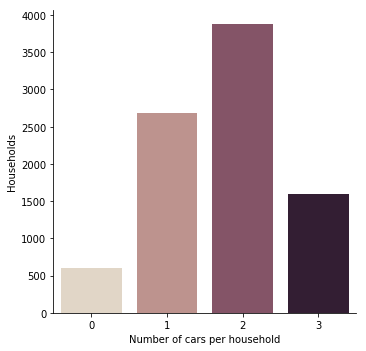

In [496]:
sns.catplot(x = 'cars_alt', kind="count", palette="ch:.25", data=df_merge)
plt.xlabel('Number of cars per household')
plt.ylabel('Households');

In [497]:
#Getting variables names for each data source
accessibility_var = set(parcels_acc) - set(parcels)
parcel_var = set(parcels.columns) - set(accessibility_var)
households_var_continious = ['INCOM','PERNO','AGE', 'EMPLY', 'children', 'TransitPass']                          
households_var_dummy = ['zone_id_home', 'HHLIC']
dependent_var = ['cars_alt']

In [507]:
final_var = list(accessibility_var) + households_var_continious + households_var_dummy + dependent_var

#Creating a dataset with varaibles needed
df = df_merge.loc[:,final_var]

In [508]:
to_normalize =  households_var_continious + list(accessibility_var) 

for i in to_normalize:
    df[i] = normalize(df[i])


In [509]:
#Splitting the data
x = df.drop(['cars_alt'], axis = 1)
y = df_merge.loc[:,'cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)#, random_state= 2348)

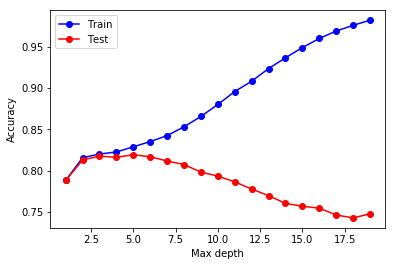

In [436]:
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
    
plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()

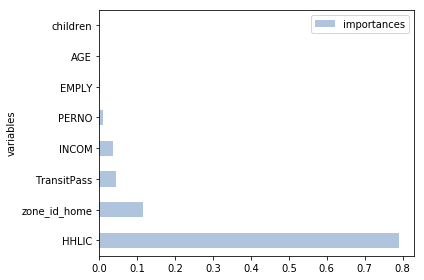

In [437]:
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter = 'best', 
                                  max_depth= 5)#, max_leaf_nodes= 8)#, 
#                                   min_weight_fraction_leaf = 0.2 )
clf.fit(X_train, y_train)

aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

aa[:20].plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks()#(fontsize = 10)
plt.tight_layout()

In [438]:
pd.crosstab( y_test, clf.predict(X_test),normalize = 'index')

col_0,0,1,2
cars_alt,,,
0,0.444976,0.497608,0.057416
1,0.016892,0.688063,0.295045
2,0.000557,0.083055,0.916388


In [439]:
clf.score(X_test, y_test)

0.812175717744725

In [408]:
clf = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_depth=10)
scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
scores

{'fit_time': array([58.36321735, 57.91968894, 57.57766199]),
 'score_time': array([0.39695263, 0.40174842, 0.40028405]),
 'test_score': array([0.63599182, 0.66308793, 0.67161125]),
 'train_score': array([0.87522373, 0.86601892, 0.86809816])}

In [ ]:
result_train_rf = []
result_test_rf = []
tree_num = range(100,1001,100)
max_depth = range(1,20)
for i in max_depth:
    clf = RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth= i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train_rf.append(scores['train_score'].mean())
    result_test_rf.append(scores['test_score'].mean()) 

plt.figure()
plt.plot(max_depth, result_train_rf, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test_rf, '-o',color='red',label='Test')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

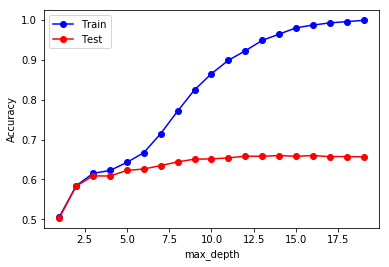

In [192]:
plt.figure()
plt.plot(max_depth, result_train_rf, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test_rf, '-o',color='red',label='Test')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

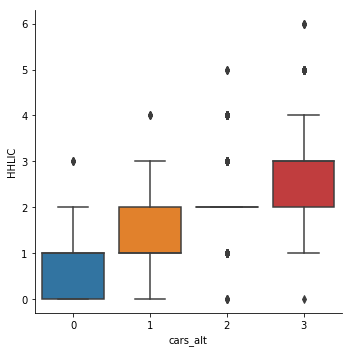

In [205]:
sns.catplot(x="cars_alt", y='HHLIC', kind="box", data=df);

In [516]:
from sklearn.neural_network import MLPClassifier



0.6845382220684885

In [526]:
mlp = MLPClassifier(hidden_layer_sizes=(5,15), activation = 'logistic')

mlp.fit(X_train, y_train)
# mlp.score(X_train, y_train)
mlp.score(X_test, y_test)

0.6997578692493946

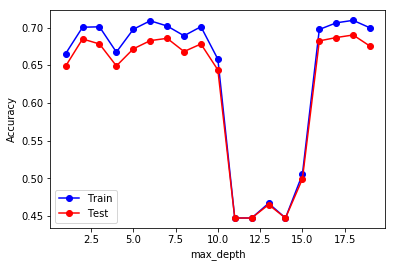

In [527]:
result_train_rf = []
result_test_rf = []
# tree_num = range(100,1001,100)
max_depth = range(1,20)
for i in max_depth:
    mlp = MLPClassifier(hidden_layer_sizes=(5,15), activation = 'logistic')
    scores = cross_validate(mlp, X_train, y_train, cv=3, return_train_score=True)
    result_train_rf.append(scores['train_score'].mean())
    result_test_rf.append(scores['test_score'].mean()) 

plt.figure()
plt.plot(max_depth, result_train_rf, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test_rf, '-o',color='red',label='Test')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

## Data cleaning

In [13]:
# hh_merged.columns[:100]  #'building_type', 'land_value', 'acres', 'tract'

In [14]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    if data.dtype == 'O':
        return 0
    else:
        return (data - np.mean(data)) / np.std(data)

In [15]:
#Creating our dependent varaible
hh_merged['cars_alt'] = hh_merged['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
# hh_merged['cars_alt'] = hh_merged['cars'].apply(lambda x: 0*(x==0)+ 1*(x>=1))

In [27]:
#Getting variables names for each data source
transit_acc_var = set(parcels_with_acc.columns) - set(parcels.columns)
nodessmall_var = set(nodessmall) - set(households)
nodeswalk_var = set(nodeswalk) - set(households)
parcel_var = set(parcels.columns) - set(filter_col) - set(transit_acc_var)
# buildings_var = set(orca.get_table('buildings').to_frame().columns)
# units_var = set(orca.get_table('units').to_frame().columns)
households_var_continious = ['age_of_head','children','hh_16_younger','hh_70_older',
                            'hh_student','hh_work_home','income',
                            'land_value', 'acres']
households_var_dummy = ['tract','hispanic_head','recent_mover','race_of_head',
                        'hh_size_1per', 'building_type','persons','workers']
dependent_var = ['cars_alt']


In [28]:
final_var = (list((transit_acc_var and nodessmall_var and nodeswalk_var )) +
             households_var_continious + households_var_dummy + dependent_var)

#Creating a dataset with varaibles needed
df = hh_merged.loc[:,['serialno'] + final_var]

#Modifying Hispanic head varaible
df.hispanic_head = df.hispanic_head.apply(lambda x: 1 if x=='yes' else 0)

In [29]:
to_normalize = list((transit_acc_var and nodessmall_var and nodeswalk_var )) + households_var_continious

for i in to_normalize:
    df[i] = normalize(df[i])

In [19]:
# df.sample(5000).corr()['cars_alt'].sort_values()


## EDA

In [20]:
import seaborn as sns

In [33]:
eda_df = df.sample(5000)

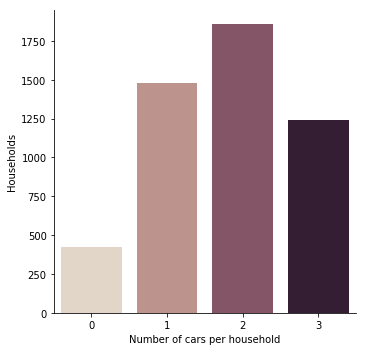

In [34]:
sns.catplot(x="cars_alt", kind="count", palette="ch:.25", data=eda_df)
plt.xlabel('Number of cars per household')
plt.ylabel('Households');

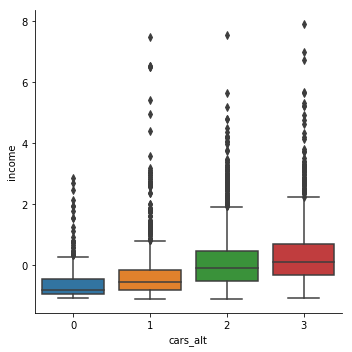

In [35]:
sns.catplot(x="cars_alt", y="income", kind="box", data=eda_df);

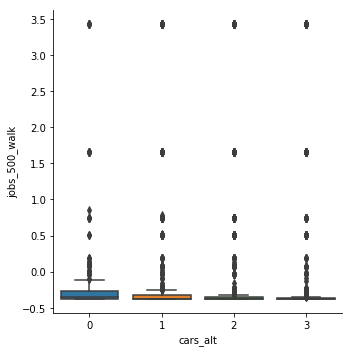

In [36]:
sns.catplot(x="cars_alt", y="jobs_500_walk", kind="box", data=eda_df);

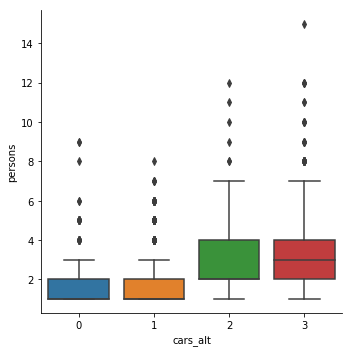

In [37]:
sns.catplot(x="cars_alt", y="persons", kind="box", data=eda_df);

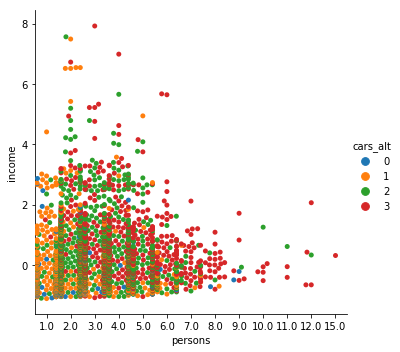

In [38]:
sns.catplot(x="persons", y="income", hue="cars_alt", kind="swarm", data=eda_df);

In [74]:
df.columns

Index(['serialno', 'jobs_500_walk', 'prop_elderly_500_walk',
       'units_mf_500_walk', 'prop_poor_500_walk', 'pop_1500_walk',
       'pop_black_1500_walk', 'avg_income_500_walk', 'jobs_1500_walk_tech',
       'jobs_500_walk_retail', 'jobs_2500_walk_serv', 'rich_500_walk',
       'pop_hisp_500_walk', 'pop_asian_1500_walk', 'prop_white_500_walk',
       'jobs_500_walk_fire', 'prop_asian_500_walk', 'jobs_500_walk_tech',
       'units_mf_1500_walk', 'children_500_walk', 'prop_hisp_1500_walk',
       'avg_hhs_500_walk', 'pop_white_500_walk', 'units_1500_walk',
       'hh_500_walk', 'prop_asian_1500_walk', 'prop_singles_500_walk',
       'prop_rich_500_walk', 'sqft_unit_500_walk', 'prop_black_500_walk',
       'prop_singles_1500_walk', 'avg_rent_500_walk', 'pop_asian_500_walk',
       'singles_1500_walk', 'pop_white_2500_walk', 'jobs_1500_walk_fire',
       'avg_hhs_1500_walk', 'prop_children_500_walk', 'avg_income_1500_walk',
       'units_sf_1500_walk', 'pop_jobs_ratio_1500_walk', 'poor_

In [39]:
#Training and test index
import random
index_list = df.serialno.unique()

# train_index = np.array(random.sample(list(index_list), int(len(index_list)*0.66) ))
train_index = np.array(random.sample(list(index_list), 1000,  ))
test_index = index_list[~np.isin(index_list,train_index )]

#Training and test set 
X_train = df[df.serialno.isin(train_index)].drop(['serialno', 'cars_alt'], axis=1)
y_train = df[df.serialno.isin(train_index)].loc[:,['cars_alt']].cars_alt

X_test = df[df.serialno.isin(test_index)].drop(['serialno', 'cars_alt'], axis=1)
y_test = df[df.serialno.isin(test_index)].loc[:,['cars_alt']].cars_alt

# Machine Learning Approach 

## Decision Tree

In [40]:
from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt

In [89]:
# #Splitting the data
# x = df_data.drop('cars_alt', axis = 1)
# y = df_data.loc[:,'cars_alt']
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

In [42]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=7)
scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
scores

{'fit_time': array([0.73664927, 0.96458364, 0.98184776]),
 'score_time': array([0.05609798, 0.05450416, 0.05286956]),
 'test_score': array([0.91579527, 0.83376909, 0.7648273 ]),
 'train_score': array([0.99621577, 0.98878569, 0.98424493])}

In [43]:
result_train = []
result_test = []
max_depth = range(1,10)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 


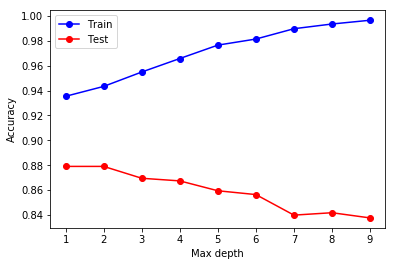

In [44]:
plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()

In [51]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=10)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
# clf.fit(X_train, y_train)
# tree_importance = clf.feature_importances_

In [53]:
aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

# aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
# plt.yticks()#(fontsize = 10)
# plt.tight_layout()
aa[:10]

,importances,variables
87,0.265513,tract
82,0.246260,income
92,0.167300,building_type
76,0.129312,age_of_head
28,0.025571,prop_black_500_walk
91,0.023788,hh_size_1per
89,0.020534,recent_mover
63,0.017834,jobs_2500_walk_tech
79,0.017376,hh_70_older
77,0.015577,children


In [54]:
pd.crosstab( y_test, clf.predict(X_test), normalize = 'index')

col_0,0,1
cars_alt,,
0,0.422603,0.577397
1,0.052196,0.947804


In [55]:
clf.score(X_test, y_test)

0.9043058165040957

## Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=20)
scores = cross_validate(clf, X_train, y_train.cars_alt, cv=3, return_train_score=True)
scores

{'fit_time': array([38.94936776, 38.15188956, 41.07851458]),
 'score_time': array([0.65718699, 0.61905003, 0.57831907]),
 'test_score': array([0.5617013 , 0.52985137, 0.52904731]),
 'train_score': array([0.64631605, 0.6767145 , 0.66101318])}

In [254]:
y_train.shape

(438258, 1)

In [39]:
# clf = RandomForestClassifier(n_estimators=1500,criterion='entropy',max_depth=20)
# clf.fit(X_train, y_train)

In [ ]:
aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

# aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
# plt.yticks()#(fontsize = 10)
# plt.tight_layout()
aa[:10]

In [ ]:
pd.crosstab( y_test.cars_alt, clf.predict(X_test), normalize = 'index')

In [ ]:
clf.score(X_test, y_test)

In [40]:
# result_train_rf = []
# result_test_rf = []
# tree_num = range(100,1001,100)
# for i in tree_num:
#     clf = RandomForestClassifier(n_estimators=i,criterion='entropy',max_depth=20)
#     scores = cross_validate(clf, X_train, y_train.cars_alt, cv=3, return_train_score=True)
#     result_train_rf.append(scores['train_score'].mean())
#     result_test_rf.append(scores['test_score'].mean()) 

# plt.figure()
# plt.plot(tree_num, result_train_rf, '-o',color='blue',label='Train')
# plt.plot(tree_num, result_test_rf, '-o',color='red',label='Test')
# plt.xlabel('Number of trees')
# plt.ylabel('Accuracy')
# plt.legend()

In [ ]:
clf_rf = RandomForestClassifier(criterion='entropy',max_depth=30, n_estimators=50)
# scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
# print (scores)

clf_rf.fit(X_train, y_train)

aa = pd.DataFrame({'importances':clf_rf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks()#(fontsize = 10)
plt.tight_layout()


In [ ]:
pd.crosstab( y_test, clf_rf.predict(X_test),normalize = 'index')

In [180]:
clf_rf.score(X_test, y_test)

0.9226607027788842

## Nueral network

In [ ]:
from sklearn.neural_network import MLPClassifier